<a href="https://colab.research.google.com/github/tamandua01/61600Datascience/blob/main/Proyecto_ParteIII_Bellesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

Based on the project:
https://www.kaggle.com/code/fahadmehfoooz/rain-prediction-with-90-65-accuracy/notebook

I wanted to do something similar, but with my own database. The ideal would be not to have a database for a specific location, but to obtain the history of any location and be able to do the analysis of it.
I found an API which allows obtaining the historical data of the meteorological center closest to the given coordinates. This API belongs to:

https://dev.meteostat.net/

# Objetive:

The idea is to develop something simple for the user, which by copying the Google Maps link returns the forecast for the next day. This would be a start, and possibly other types of information could be forecast.

# Commercial context:
At this stage, its functionality is purely recreational. But if it works, it could be developed to obtain other types of information. For example, selling the amount of ml of rain or hours of sunshine in a given location, which could be useful for making decisions about crops or installing a solar panel, for example. It could also estimate the direction and strength of the wind to install windmills.

# Hypothesis:
Using historical weather data from a location and a machine learning model, it is possible to accurately classify whether or not it will rain the next day, based on attributes such as temperature, humidity, precipitation, etc.
It is possible that if this model works well, another one could be used that also predicts how much it will rain.

# Libraries

In [1]:
pip install meteostat

In [2]:
pip install altair

In [3]:
!pip install altair-viewer

In [4]:
pip install seaborn ptitprince


In [5]:
pip install matplotlib==3.7.3

In [6]:
import pandas as pd
import numpy as np

import warnings
import re
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly
# Import Meteostat library
from meteostat import Stations
from IPython.display import display, HTML
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import missingno as msno
import ptitprince as pt


# Place Google Maps location link

In [7]:
# To obtain Coordinates, change the link between '' :
url_maps = 'https://www.google.com/maps/place/Centro+C%C3%ADvico+Bariloche/@-41.133496,-71.3102123,826m/data=!3m2!1e3!4b1!4m6!3m5!1s0x961a7b72dbb708e1:0xd91b7e92f820aa94!8m2!3d-41.133496!4d-71.3102123!16s%2Fg%2F12215pwy?entry=ttu&g_ep=EgoyMDI0MTEyNC4xIKXMDSoASAFQAw%3D%3D'

# Data Frame Creation

The raw dataframe is obtained from an API. For this, the longitude and latitude are given, the way it works is to search for the nearest weather station and return the dataframe with the historical data. To obtain the coordinates, the code uses regular expressions to search for them within the Google Maps link.

In [8]:
#This step has the function of obtaining the coordinates within the link

def get_coordinates(url_maps):
    # Use a regular expression to find the pattern between '@' and the second ','
    pattern = r'@(-?[0-9.]+),(-?[0-9.]+)'
    match = re.search(pattern, url_maps)

    if match:
        # Convert the latitude and longitude to float (numerical values)
        latitude = float(match.group(1))
        longitude = float(match.group(2))
        return latitude, longitude
    else:
        return None

coordinates = get_coordinates(url_maps)
if coordinates:
    latitude, longitude = coordinates
    print(f"Latitude: {latitude}, Longitude: {longitude}")
else:
    print("No coordinates found.")

Latitude: -41.133496, Longitude: -71.3102123


In [9]:
# Get nearby weather stations
stations = Stations()
stations = stations.nearby(latitude,longitude)
station = stations.fetch(1)

# Print DataFrame
station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
87765,Bariloche Aerodrome,AR,R,87765,SAZS,-41.15,-71.1667,845.0,America/Argentina/Mendoza,1939-02-01,2025-01-27,1957-06-30,2025-01-24,1949-01-01,2022-01-01,12156.908196


In [10]:
# Extract the 'id' from the index and assign it to station_id
station_id = station.index[0]
#Change station_id to string
station_id = str(station_id)

# Print the station_id
print(f"station_id "+station_id)

# Convert 'hourly_start' to datetime if it's not already in datetime format
station['hourly_start'] = pd.to_datetime(station['hourly_start'], errors='coerce')

# Extract the year from 'hourly_start'
year = station['hourly_start'].dt.year.iloc[0]

# Print the extracted year
print(year)

#Today Date
today = datetime.today()
today

station_id 87765
1939


datetime.datetime(2025, 1, 28, 13, 8, 14, 26416)

In [11]:
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set time period
start = datetime(year, 1, 1)
end = today

# Fetch hourly data
try:
    data = Hourly(station_id, start, end)
    data = data.fetch()

    # Manually handle date parsing if necessary
    if 'time' in data.columns:  # Replace 'time' with the actual datetime column name if different
        data['time'] = pd.to_datetime(data['time'])



except Exception as e:
    print(f"An error occurred: {e}")

data

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
1939-02-01 12:00:00,8.9,0.6,56.0,NaN,NaN,340.0,16.6,NaN,NaN,NaN,NaN
1939-02-02 12:00:00,10.0,5.6,74.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1939-02-03 12:00:00,11.1,9.4,89.0,NaN,NaN,340.0,3.6,NaN,NaN,NaN,NaN
1939-02-04 12:00:00,8.9,7.8,93.0,NaN,NaN,320.0,3.6,NaN,NaN,NaN,NaN
1939-02-06 12:00:00,7.8,3.8,76.0,NaN,NaN,180.0,9.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28 09:00:00,3.3,-0.9,74.0,0.0,NaN,172.0,7.4,NaN,1018.6,NaN,1.0
2025-01-28 10:00:00,4.7,-0.5,69.0,0.0,NaN,165.0,7.4,NaN,1019.1,NaN,1.0
2025-01-28 11:00:00,7.1,-0.1,60.0,0.0,NaN,152.0,5.5,NaN,1019.2,NaN,1.0


To predict rain, two columns are created, one indicating whether it rained that day, based on the prcp (precipitation) values, and another indicating whether it will rain tomorrow based on the previous one.

In [12]:
df=data

# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)

# Create a new column with only the date (excluding the time)
df['date'] = df.index.date

# Sum daily precipitation by grouping by date
df['daily_precipitation'] = df.groupby('date')['prcp'].transform('sum')

# Add a new column 'daily_rain' with the value 'yes' if daily_precipitation > 1.0, otherwise 'no'
df['daily_rain'] = np.where(df['daily_precipitation'] > 1.0, 'yes', 'no')

# Sort the DataFrame by date to ensure proper grouping and shifting
df = df.sort_values(by='date')

# Create a new column with the 'daily_rain' value shifted by one day
df['next_day_rain'] = df.groupby('date')['daily_rain'].transform(lambda x: x.shift(-1))

# Now, fill in the next day's rain data from one day ahead
df['next_day_rain'] = df.groupby('date')['daily_rain'].transform('last').shift(-1)

In [13]:
df

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
time,,,,,,,,,,,,,,,
1939-02-01 12:00:00,8.9,0.6,56.0,NaN,NaN,340.0,16.6,NaN,NaN,NaN,NaN,1939-02-01,0.0,no,no
1939-02-02 12:00:00,10.0,5.6,74.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1939-02-02,0.0,no,no
1939-02-03 12:00:00,11.1,9.4,89.0,NaN,NaN,340.0,3.6,NaN,NaN,NaN,NaN,1939-02-03,0.0,no,no
1939-02-04 12:00:00,8.9,7.8,93.0,NaN,NaN,320.0,3.6,NaN,NaN,NaN,NaN,1939-02-04,0.0,no,no
1939-02-06 12:00:00,7.8,3.8,76.0,NaN,NaN,180.0,9.4,NaN,NaN,NaN,NaN,1939-02-06,0.0,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28 02:00:00,11.3,2.1,53.0,0.0,NaN,294.0,16.7,NaN,1017.9,NaN,1.0,2025-01-28,0.0,no,no
2025-01-28 00:00:00,14.3,0.9,40.0,0.0,NaN,293.0,27.8,NaN,1017.2,NaN,2.0,2025-01-28,0.0,no,no
2025-01-28 12:00:00,10.3,0.3,50.0,0.0,NaN,149.0,3.7,NaN,1017.7,NaN,1.0,2025-01-28,0.0,no,no


In [14]:
# Reset the index to make 'time' a separate column and set a numeric index
df = df.reset_index()

# Now 'time' is a separate column, and the index is numeric by default

# Sort the DataFrame by the 'time' column to restore order
df = df.sort_values(by='time').reset_index(drop=True)

# Display the last 10 records of the re-sorted DataFrame
df.tail(24)

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
344123,2025-01-27 14:00:00,13.5,-0.9,37.0,0.0,NaN,296.0,33.3,NaN,1015.7,NaN,2.0,2025-01-27,0.0,no,no
344124,2025-01-27 15:00:00,14.3,-1.0,35.0,0.0,NaN,297.0,33.3,NaN,1017.0,NaN,1.0,2025-01-27,0.0,no,no
344125,2025-01-27 16:00:00,15.2,-1.0,33.0,0.0,NaN,299.0,35.2,NaN,1015.1,NaN,1.0,2025-01-27,0.0,no,no
344126,2025-01-27 17:00:00,15.9,-1.7,30.0,0.0,NaN,298.0,35.2,NaN,1014.3,NaN,1.0,2025-01-27,0.0,no,no
344127,2025-01-27 18:00:00,17.0,-2.1,27.0,0.0,NaN,298.0,37.0,NaN,1015.9,NaN,1.0,2025-01-27,0.0,no,no
344128,2025-01-27 19:00:00,17.6,-2.1,26.0,0.0,NaN,297.0,37.0,NaN,1013.8,NaN,1.0,2025-01-27,0.0,no,no
344129,2025-01-27 20:00:00,17.8,-2.0,26.0,0.0,NaN,297.0,37.0,NaN,1013.3,NaN,1.0,2025-01-27,0.0,no,no
344130,2025-01-27 21:00:00,17.5,-1.7,27.0,0.0,NaN,296.0,37.0,NaN,1015.8,NaN,2.0,2025-01-27,0.0,no,no
344131,2025-01-27 22:00:00,16.9,-0.8,30.0,0.0,NaN,296.0,35.2,NaN,1015.4,NaN,1.0,2025-01-27,0.0,no,no
344132,2025-01-27 23:00:00,15.8,0.4,35.0,0.0,NaN,296.0,31.5,NaN,1015.2,NaN,2.0,2025-01-27,0.0,no,no


To obtain more columns (variables in the predictive model), the values ​​corresponding to hours 3, 6, 9, 12, 15, 18, 21 and 0 (or 24) are taken and the other schedules are eliminated.

In [15]:
# Define the target hours
target_hours = [3, 6, 9, 12, 15, 18, 21, 0]

# Filter the DataFrame for rows where the hour in 'time' matches the target hours
df_filtered = df[df['time'].dt.hour.isin(target_hours)]

# Display the filtered DataFrame
df_filtered

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
0,1939-02-01 12:00:00,8.9,0.6,56.0,NaN,NaN,340.0,16.6,NaN,NaN,NaN,NaN,1939-02-01,0.0,no,no
1,1939-02-02 12:00:00,10.0,5.6,74.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1939-02-02,0.0,no,no
2,1939-02-03 12:00:00,11.1,9.4,89.0,NaN,NaN,340.0,3.6,NaN,NaN,NaN,NaN,1939-02-03,0.0,no,no
3,1939-02-04 12:00:00,8.9,7.8,93.0,NaN,NaN,320.0,3.6,NaN,NaN,NaN,NaN,1939-02-04,0.0,no,no
4,1939-02-06 12:00:00,7.8,3.8,76.0,NaN,NaN,180.0,9.4,NaN,NaN,NaN,NaN,1939-02-06,0.0,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344133,2025-01-28 00:00:00,14.3,0.9,40.0,0.0,NaN,293.0,27.8,NaN,1017.2,NaN,2.0,2025-01-28,0.0,no,no
344136,2025-01-28 03:00:00,9.8,2.2,59.0,0.0,NaN,292.0,13.0,NaN,1019.1,NaN,1.0,2025-01-28,0.0,no,no
344139,2025-01-28 06:00:00,5.3,0.7,72.0,0.0,NaN,209.0,7.4,NaN,1019.3,NaN,1.0,2025-01-28,0.0,no,no
344142,2025-01-28 09:00:00,3.3,-0.9,74.0,0.0,NaN,172.0,7.4,NaN,1018.6,NaN,1.0,2025-01-28,0.0,no,no


In [16]:
# Extract only the hour from the 'time' column
df_filtered['time'] = df_filtered['time'].dt.hour




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
# Display the DataFrame to verify the change
df_filtered.tail()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
344133,0,14.3,0.9,40.0,0.0,NaN,293.0,27.8,NaN,1017.2,NaN,2.0,2025-01-28,0.0,no,no
344136,3,9.8,2.2,59.0,0.0,NaN,292.0,13.0,NaN,1019.1,NaN,1.0,2025-01-28,0.0,no,no
344139,6,5.3,0.7,72.0,0.0,NaN,209.0,7.4,NaN,1019.3,NaN,1.0,2025-01-28,0.0,no,no
344142,9,3.3,-0.9,74.0,0.0,NaN,172.0,7.4,NaN,1018.6,NaN,1.0,2025-01-28,0.0,no,no
344145,12,10.3,0.3,50.0,0.0,NaN,149.0,3.7,NaN,1017.7,NaN,1.0,2025-01-28,0.0,no,no


## Formats & Units

# Time Format

Date and time statements follow the ISO 8601 standard (e.g. 2016-12-31 for December 31st 2016 and 23:59:58 for 23 hours, 59 minutes, and 58 seconds). The time zone used by Meteostat is Coordinated Universal Time (UTC).

#Time Ranges
Many JSON API endpoints require the specification of a time range using the start and end parameters. For these parameters please always provide dates in this format: YYYY-MM-DD.

#Meteorological Parameters
The Meteostat API uses abbreviations to describe meteorological parameters:

Code	Meaning
TEMP	Air Temperature
TAVG	Average Temperature
TMIN	Minimum Temperature
TMAX	Maximum Temperature
DWPT	Dew Point
PRCP	Total Precipitation
WDIR	Wind (From) Direction
WSPD	Average Wind Speed
WPGT	Wind Peak Gust
RHUM	Relative Humidity
PRES	Sea-Level Air Pressure
SNOW	Snow Depth
TSUN	Total Sunshine Duration
COCO	Weather Condition Code
#Meteorological Data Units
Parameter(s)	Unit
Temperature	°C
Precipitation	mm
Sunshine Duration	Minutes
Air Pressure	hPa
Wind Speed, Peak Wind Gust	km/h
Wind Direction	Degrees
Visibility, Cloud Height	m
Relative Humidity	%
#Weather Condition Codes
Hourly weather data may include information on the observed weather condition. Please note that the weather condition is not a key parameter for Meteostat. METAR reports, issued by weather stations located at airports, only report significant weather events. Also, some weather stations do not provide weather condition data at all.

Weather conditions are indicated by an integer value between 1 and 27 according to this list:


In [18]:
# Create the Weather Condition Codes table
weather_condition_data = {
    'Code': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
    'Weather Condition': [
        'Clear', 'Fair', 'Cloudy', 'Overcast', 'Fog', 'Freezing Fog',
        'Light Rain', 'Rain', 'Heavy Rain', 'Freezing Rain', 'Heavy Freezing Rain',
        'Sleet', 'Heavy Sleet', 'Light Snowfall', 'Snowfall', 'Heavy Snowfall',
        'Rain Shower', 'Heavy Rain Shower', 'Sleet Shower', 'Heavy Sleet Shower',
        'Snow Shower', 'Heavy Snow Shower', 'Lightning', 'Hail', 'Thunderstorm',
        'Heavy Thunderstorm', 'Storm'
    ]
}

# Convert it to a DataFrame
weather_condition_df = pd.DataFrame(weather_condition_data)

# Display the DataFrame
weather_condition_df

,Code,Weather Condition
0,1,Clear
1,2,Fair
2,3,Cloudy
3,4,Overcast
4,5,Fog
5,6,Freezing Fog
6,7,Light Rain
7,8,Rain
8,9,Heavy Rain
9,10,Freezing Rain


# Data selection and cleaning

Not all dates have all Hours (old records). Therefore, in order for the dataset to be as complete and homogeneous as possible, the dates in which this condition is not met are eliminated.

In [19]:
# Group by 'date' and count the number of rows for each date
date_counts = df_filtered.groupby('date').size().reset_index(name='count')

# Display the resulting table
date_counts

,date,count
0,1939-02-01,1
1,1939-02-02,1
2,1939-02-03,1
3,1939-02-04,1
4,1939-02-06,1
...,...,...
22779,2025-01-24,8
22780,2025-01-25,8
22781,2025-01-26,8
22782,2025-01-27,8


In [20]:
# Get all dates where the count is not equal to 8
dates_to_remove = date_counts[date_counts['count'] != 8]['date']

# Filter out rows in df_filtered where 'date' is in dates_to_remove
df_filtered = df_filtered[~df_filtered['date'].isin(dates_to_remove)]

# Display the updated df_filtered
df_filtered


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,date,daily_precipitation,daily_rain,next_day_rain
9167,0,15.0,7.1,59.0,NaN,NaN,290.0,40.7,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
9168,3,18.0,10.1,60.0,NaN,NaN,140.0,18.4,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
9169,6,10.0,7.9,87.0,NaN,NaN,290.0,20.2,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
9171,9,5.0,3.0,87.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
9173,12,9.0,4.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1973-02-03,0.0,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344118,9,8.0,-2.1,49.0,0.0,NaN,280.0,13.0,NaN,1013.0,NaN,2.0,2025-01-27,0.0,no,no
344121,12,11.8,0.5,46.0,0.0,NaN,295.0,31.5,NaN,1017.0,NaN,2.0,2025-01-27,0.0,no,no
344124,15,14.3,-1.0,35.0,0.0,NaN,297.0,33.3,NaN,1017.0,NaN,1.0,2025-01-27,0.0,no,no
344127,18,17.0,-2.1,27.0,0.0,NaN,298.0,37.0,NaN,1015.9,NaN,1.0,2025-01-27,0.0,no,no


Many locations take more data as time goes by, so the most complete information will always be the most recent. This is why, to handle nulls, the first non-null value of each column is searched for and the previous records are eliminated. This is done sequentially for each column, and if the entire column has no values, it is completely eliminated. The prcp column is a special case, since it is the main column for the project, so if it has no values, a message appears stating that this location is not useful for the project.

In [21]:
# Check if there are any non-NaN values in the 'prcp' column
if df_filtered['prcp'].notna().any():
    # Find the first date where 'prcp' is not NaN
    first_date_with_prcp = df_filtered[df_filtered['prcp'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_prcp]
    # Display the result
    print("First date with prcp data:", first_date_with_prcp)
else:
    # If all values are NaN, drop the 'prcp' column and display an alert message
    df_filtered = df_filtered.drop(columns=['prcp'])
    display(HTML("""
        <h3 style="color:red;">Dataset Incompatible for Rain Forecasting</h3>
        <p>The dataset does not contain any precipitation ('prcp') data. Please select a different location to forecast rain.</p>
    """))
    # Stop further execution in the notebook
    sys.exit("Execution stopped due to missing precipitation data.")


First date with prcp data: 2022-05-24


In [22]:
# Check if there are any non-NaN values in the 'wpgt' column
if df_filtered['wpgt'].notna().any():
    # Find the first date where 'wpgt' is not NaN
    first_date_with_wpgt = df_filtered[df_filtered['wpgt'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_wpgt]
    # Display the result
    print("First date with wpgt data:", first_date_with_wpgt)
else:
    # If all values are NaN, drop the 'wpgt' column
    df_filtered = df_filtered.drop(columns=['wpgt'])
    print("'wpgt' column has been removed due to all values being NaN.")

'wpgt' column has been removed due to all values being NaN.


In [23]:
# Check if there are any non-NaN values in the 'snow' column
if df_filtered['snow'].notna().any():
    # Find the first date where 'snow' is not NaN
    first_date_with_snow = df_filtered[df_filtered['snow'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_snow]
    # Display the result
    print("First date with snow data:", first_date_with_snow)
else:
    # If all values are NaN, drop the 'snow' column
    df_filtered = df_filtered.drop(columns=['snow'])
    print("'snow' column has been removed due to all values being NaN.")

'snow' column has been removed due to all values being NaN.


In [24]:
# Check if there are any non-NaN values in the 'tsun' column
if df_filtered['tsun'].notna().any():
    # Find the first date where 'tsun' is not NaN
    first_date_with_tsun = df_filtered[df_filtered['tsun'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_tsun]
    # Display the result
    print("First date with tsun data:", first_date_with_tsun)
else:
    # If all values are NaN, drop the 'tsun' column
    df_filtered = df_filtered.drop(columns=['tsun'])
    print("'tsun' column has been removed due to all values being NaN.")


'tsun' column has been removed due to all values being NaN.


In [25]:
# Check if there are any non-NaN values in the 'coco' column
if df_filtered['coco'].notna().any():
    # Find the first date where 'coco' is not NaN
    first_date_with_coco = df_filtered[df_filtered['coco'].notna()]['date'].iloc[0]
    # Remove all rows before this date
    df_filtered = df_filtered[df_filtered['date'] >= first_date_with_coco]
    # Display the result
    print("First date with coco data:", first_date_with_coco)
else:
    # If all values are NaN, drop the 'coco' column
    df_filtered = df_filtered.drop(columns=['coco'])
    print("'coco' column has been removed due to all values being NaN.")


First date with coco data: 2022-05-24


In [26]:
df_filtered

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,date,daily_precipitation,daily_rain,next_day_rain
320613,0,2.7,0.3,84.0,NaN,290.0,29.5,1008.0,8.0,2022-05-24,4.2,yes,yes
320616,3,1.6,0.1,90.0,NaN,270.0,11.2,1009.0,7.0,2022-05-24,4.2,yes,yes
320619,6,3.2,0.8,84.0,NaN,320.0,25.9,1008.0,7.0,2022-05-24,4.2,yes,yes
320622,9,2.8,-1.0,76.0,NaN,290.0,40.7,1013.0,7.0,2022-05-24,4.2,yes,yes
320625,12,2.3,-0.1,84.0,NaN,290.0,35.3,1010.0,8.0,2022-05-24,4.2,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
344118,9,8.0,-2.1,49.0,0.0,280.0,13.0,1013.0,2.0,2025-01-27,0.0,no,no
344121,12,11.8,0.5,46.0,0.0,295.0,31.5,1017.0,2.0,2025-01-27,0.0,no,no
344124,15,14.3,-1.0,35.0,0.0,297.0,33.3,1017.0,1.0,2025-01-27,0.0,no,no
344127,18,17.0,-2.1,27.0,0.0,298.0,37.0,1015.9,1.0,2025-01-27,0.0,no,no


Nulls in the raw original dataframe

In [27]:
# Count the number of NaN values in each column of df
nan_counts = df.isna().sum()

# Display the result
nan_counts



,0
time,0
temp,4532
dwpt,6561
rhum,6561
prcp,320899
snow,344147
wdir,57359
wspd,2346
wpgt,344147
pres,264091


<Axes: >

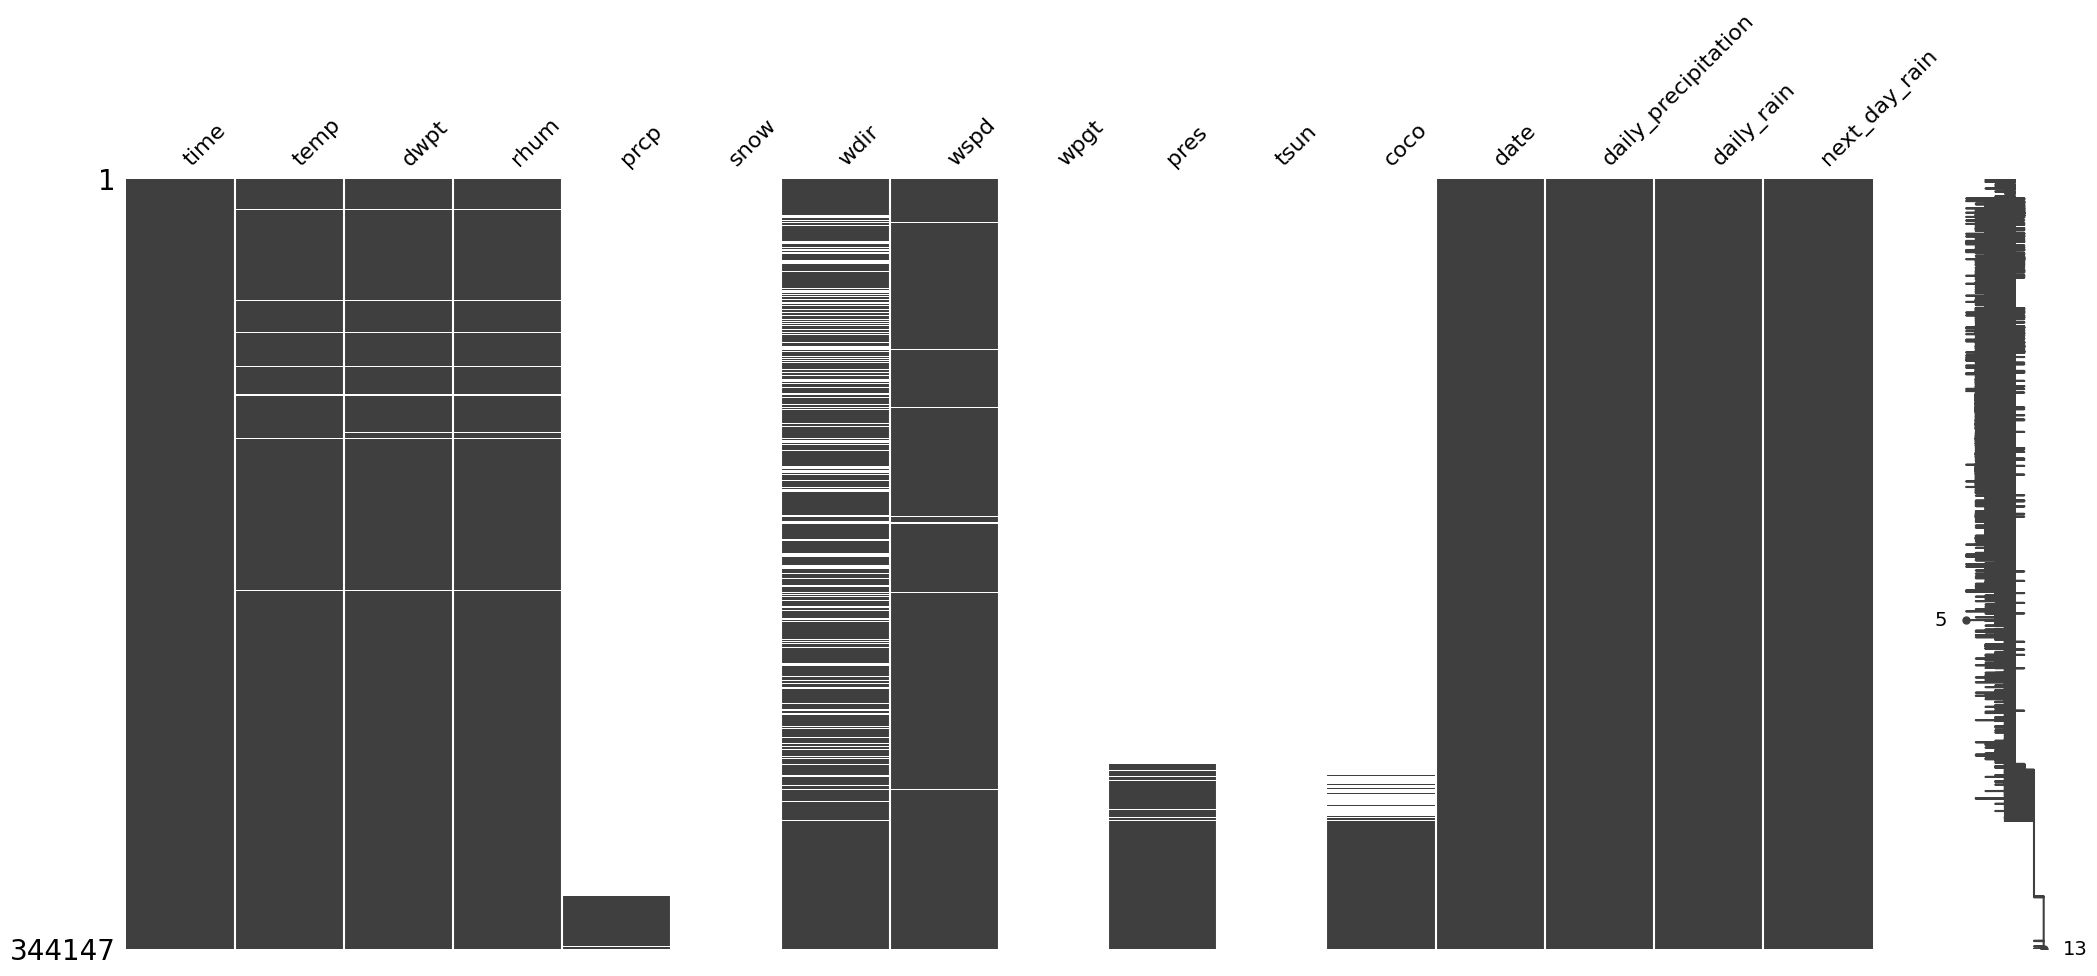

In [28]:
msno.matrix(df)

Nulls in the filtered dataframe

In [29]:
# Count the number of NaN values in each column of df_filtered
nan_counts = df_filtered.isna().sum()

# Display the result
nan_counts

,0
time,0
temp,0
dwpt,0
rhum,0
prcp,95
wdir,0
wspd,0
pres,0
coco,73
date,0


<Axes: >

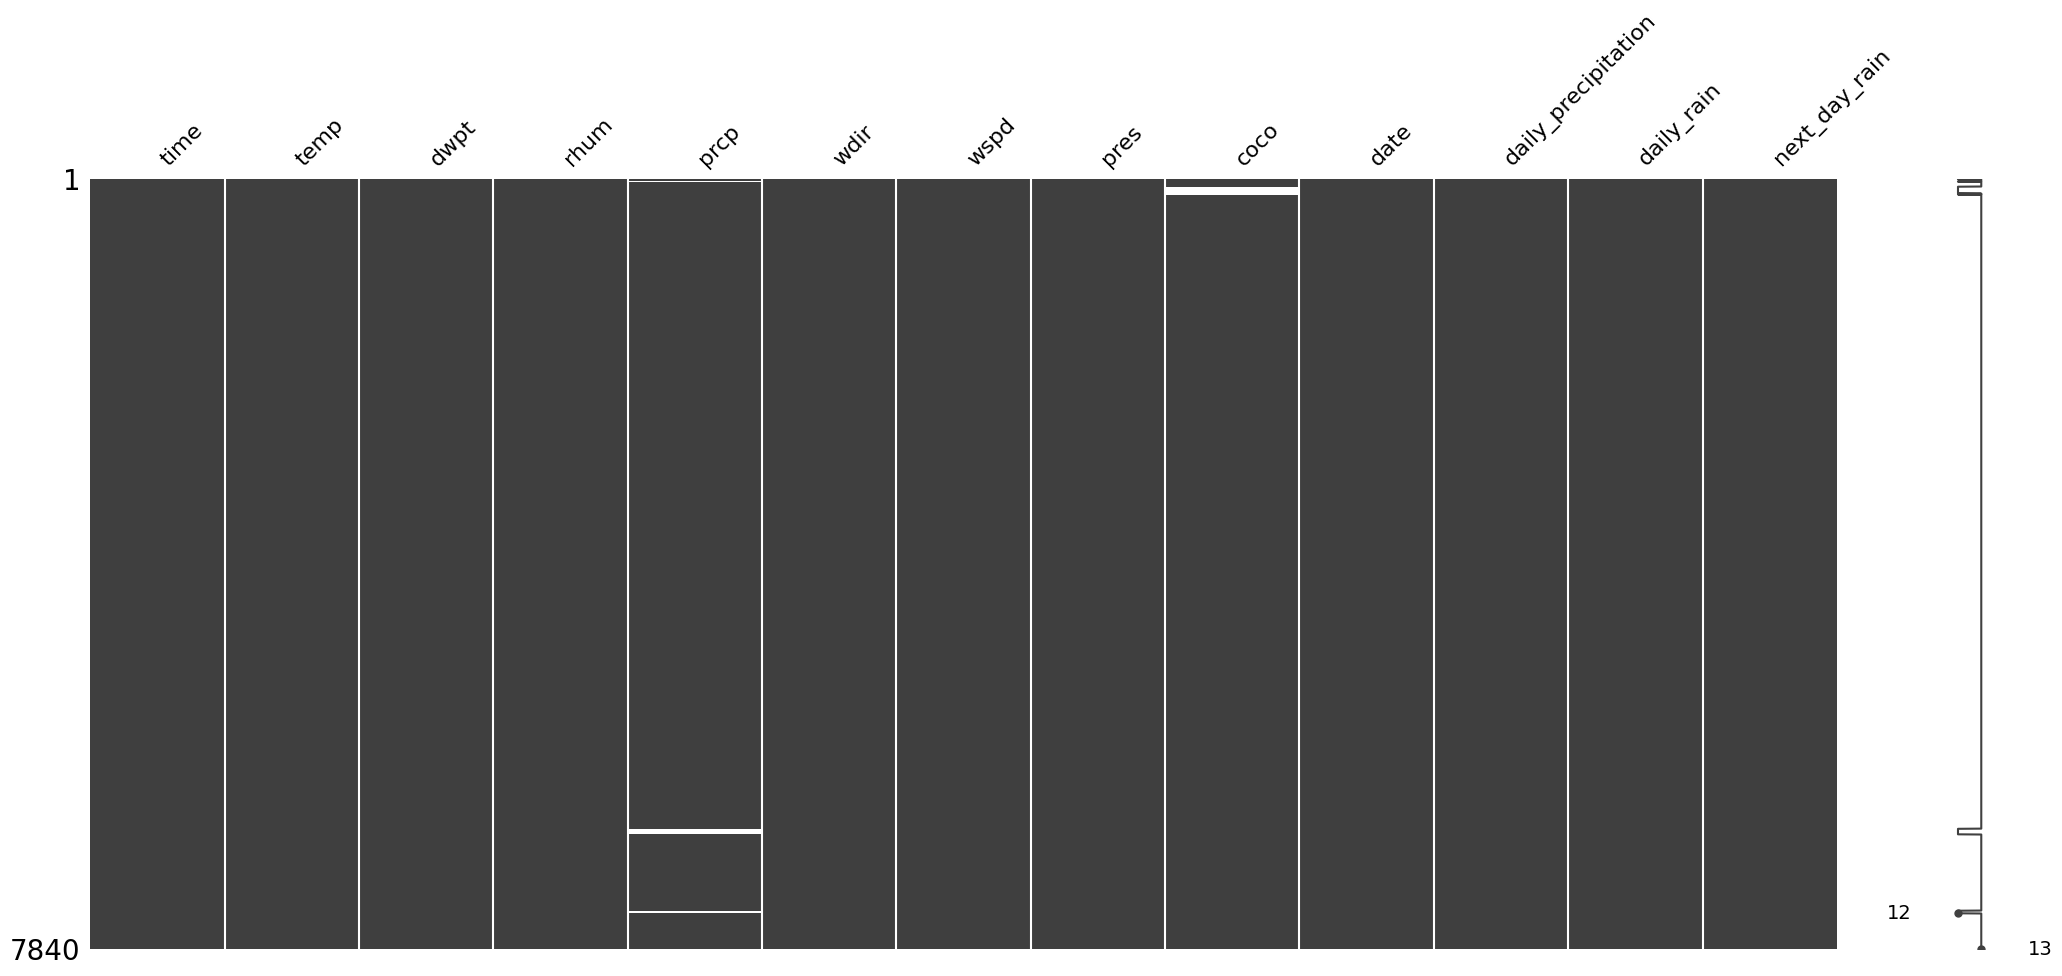

In [30]:
msno.matrix(df_filtered)

Nulls are filled with 0, assuming that the lack of data is due to the lack of positive records. For example, if there was no snow, they leave it empty. The only column that is filled with another value is the wind direction, which is filled with 365. It takes the value but does not appear on the graphic.

In [31]:
# Define the columns and values for filling NaNs
fill_values = {
    'prcp': 0,
    'snow': 0,
    'wspd': 0,
    'wpgt': 0,
    'tsun': 0,
    'coco': 0,
    'wdir': 365
}

# Fill NaNs only in the columns that exist in df_filtered
for column, value in fill_values.items():
    if column in df_filtered.columns:
        df_filtered[column].fillna(value, inplace=True)

# Display the updated DataFrame
df_filtered


,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,date,daily_precipitation,daily_rain,next_day_rain
320613,0,2.7,0.3,84.0,0.0,290.0,29.5,1008.0,8.0,2022-05-24,4.2,yes,yes
320616,3,1.6,0.1,90.0,0.0,270.0,11.2,1009.0,7.0,2022-05-24,4.2,yes,yes
320619,6,3.2,0.8,84.0,0.0,320.0,25.9,1008.0,7.0,2022-05-24,4.2,yes,yes
320622,9,2.8,-1.0,76.0,0.0,290.0,40.7,1013.0,7.0,2022-05-24,4.2,yes,yes
320625,12,2.3,-0.1,84.0,0.0,290.0,35.3,1010.0,8.0,2022-05-24,4.2,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
344118,9,8.0,-2.1,49.0,0.0,280.0,13.0,1013.0,2.0,2025-01-27,0.0,no,no
344121,12,11.8,0.5,46.0,0.0,295.0,31.5,1017.0,2.0,2025-01-27,0.0,no,no
344124,15,14.3,-1.0,35.0,0.0,297.0,33.3,1017.0,1.0,2025-01-27,0.0,no,no
344127,18,17.0,-2.1,27.0,0.0,298.0,37.0,1015.9,1.0,2025-01-27,0.0,no,no


Once the data is ready, the pivoting is done to have one row per day and the values ​​for each hour are represented as individual columns. This helps to have more columns and therefore more variables to use with the models.

In [32]:
# List of columns to exclude from pivoting
exclude_columns = ['date', 'time', 'daily_precipitation', 'daily_rain', 'next_day_rain']

# Separate columns to be duplicated and columns to pivot
fixed_columns = ['daily_precipitation', 'daily_rain', 'next_day_rain']
pivot_columns = [col for col in df_filtered.columns if col not in exclude_columns]

# Set the index to 'date' and 'time' to prepare for pivoting
df_filtered.set_index(['date', 'time'], inplace=True)

# Pivot the DataFrame, renaming columns with the hour suffix
df_pivoted = df_filtered[pivot_columns].unstack(level=-1)
df_pivoted.columns = [f"{col}_{int(hour)}" for col, hour in df_pivoted.columns]

# Reset the index to bring 'date' back as a column
df_pivoted.reset_index(inplace=True)

# Add the fixed columns (which are consistent across the day) to the new DataFrame
for col in fixed_columns:
    df_pivoted[col] = df_filtered.groupby('date')[col].first().values




In [33]:
# Display the new table
df_pivoted

,date,temp_0,temp_3,temp_6,temp_9,temp_12,temp_15,temp_18,temp_21,dwpt_0,...,coco_3,coco_6,coco_9,coco_12,coco_15,coco_18,coco_21,daily_precipitation,daily_rain,next_day_rain
0,2022-05-24,2.7,1.6,3.2,2.8,2.3,1.4,3.3,3.1,0.3,...,7.0,7.0,7.0,8.0,8.0,8.0,7.0,4.2,yes,yes
1,2022-05-25,2.4,1.3,-1.9,-3.6,-5.0,-0.4,3.1,3.6,0.5,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,0.0,no,no
2,2022-05-26,-2.0,-5.2,-6.8,-8.1,-5.9,-1.7,1.0,0.5,-4.7,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,no,no
3,2022-05-27,-3.1,-4.8,-6.8,-4.4,-3.7,-0.9,1.7,2.7,-5.3,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,no,no
4,2022-05-28,-2.4,-4.2,-5.4,-7.5,-6.1,-0.4,3.7,2.4,-5.5,...,2.0,2.0,2.0,2.0,3.0,2.0,2.0,0.0,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,2025-01-23,19.0,16.0,15.0,13.0,15.0,18.0,17.0,15.0,1.9,...,3.0,3.0,4.0,3.0,3.0,2.0,3.0,1.7,yes,yes
976,2025-01-24,13.0,12.0,11.0,10.0,13.0,16.0,18.0,19.0,3.9,...,3.0,3.0,3.0,2.0,3.0,3.0,2.0,0.0,no,no
977,2025-01-25,15.0,11.0,4.0,3.0,12.0,18.0,24.0,26.0,4.9,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,no,no
978,2025-01-26,21.0,17.0,11.0,8.0,16.0,25.0,25.0,21.0,6.9,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,no,no


In [34]:
# Count the number of NaN values in each column of df_pivoted
nan_counts = df_pivoted.isna().sum()

# Display the result
nan_counts

,0
date,0
temp_0,0
temp_3,0
temp_6,0
temp_9,0
...,...
coco_18,0
coco_21,0
daily_precipitation,0
daily_rain,0


# Descriptive statistics

Due to the nature of the project, all data will change based on the location of analysis. So they will be shown but not mentioned in detail as it changes with each location.

In [35]:
#Row Count, Column Count
df_pivoted.shape

(980, 68)

In [36]:
#Counting duplicates
df_pivoted.duplicated().value_counts()

,count
False,980


In [37]:
#Table Info
df_pivoted.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 68 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 980 non-null    object 
 1   temp_0               980 non-null    float64
 2   temp_3               980 non-null    float64
 3   temp_6               980 non-null    float64
 4   temp_9               980 non-null    float64
 5   temp_12              980 non-null    float64
 6   temp_15              980 non-null    float64
 7   temp_18              980 non-null    float64
 8   temp_21              980 non-null    float64
 9   dwpt_0               980 non-null    float64
 10  dwpt_3               980 non-null    float64
 11  dwpt_6               980 non-null    float64
 12  dwpt_9               980 non-null    float64
 13  dwpt_12              980 non-null    float64
 14  dwpt_15              980 non-null    float64
 15  dwpt_18              980 non-null    flo

# Categorical columns

In [38]:
df_pivoted.describe(include = 'object').T

,count,unique,top,freq
date,980,980,2022-05-24,1
daily_rain,980,2,no,696
next_day_rain,980,2,no,697


It should be noted that there are other categorical columns but since they are represented by numerical values ​​they will appear as numeric.

# Numeric Columns

In [39]:
df_pivoted.describe().T

,count,mean,std,min,25%,50%,75%,max
temp_0,980.0,9.049082,6.933169,-3.1,3.4,7.75,14.1,31.4
temp_3,980.0,6.808980,5.750014,-5.2,2.2,6.00,11.4,22.8
temp_6,980.0,5.163469,5.157162,-7.0,1.2,4.80,9.0,20.3
temp_9,980.0,4.042041,4.870135,-8.1,0.6,3.50,7.4,18.5
temp_12,980.0,6.349286,6.308563,-8.2,1.6,5.85,11.4,23.5
...,...,...,...,...,...,...,...,...
coco_12,980.0,3.502041,3.052987,0.0,2.0,3.00,3.0,16.0
coco_15,980.0,3.452041,3.124379,0.0,2.0,3.00,3.0,19.0
coco_18,980.0,3.372449,2.930774,0.0,2.0,3.00,3.0,19.0
coco_21,980.0,3.615306,3.240444,0.0,2.0,3.00,3.0,25.0


As mentioned in the previous point, some columns present at this point are actually categorical, but converted into numerical values ​​to use the models.

# Graphic representations

Minimum, Maximum, and Average Temperature(temp) by Hour

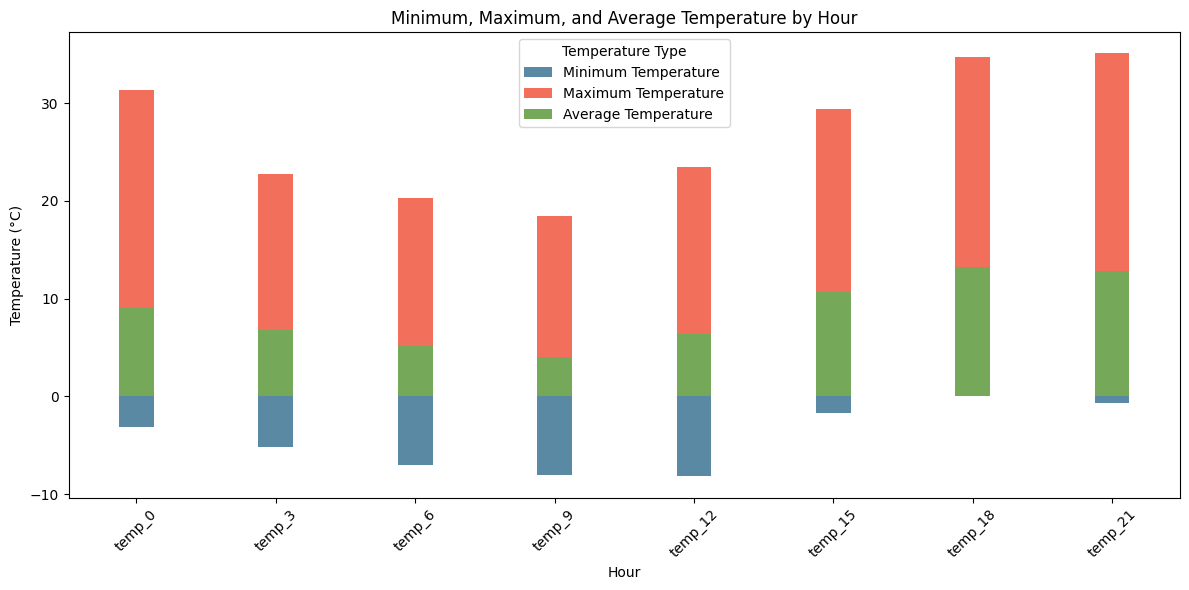

In [40]:
# List of temperature columns
cols = ['temp_0', 'temp_3', 'temp_6', 'temp_9', 'temp_12', 'temp_15', 'temp_18', 'temp_21']

# Get the minimum, maximum, and average values for each column
min_values = df_pivoted[cols].min()
max_values = df_pivoted[cols].max()
avg_values = df_pivoted[cols].mean()

# Combine these values into a single DataFrame
temperature_values = pd.DataFrame({
    'Hour': min_values.index.tolist() * 3,
    'Temperature': pd.concat([min_values, max_values, avg_values], axis=0),
    'Type': ['Minimum Temperature'] * len(min_values) + ['Maximum Temperature'] * len(max_values) + ['Average Temperature'] * len(avg_values)
})

# Plot the result
plt.figure(figsize=(12, 6))

# Softer, more subdued colors for the temperature types
colors = {'Minimum Temperature': '#5A89A4', 'Maximum Temperature': '#F16F5B', 'Average Temperature': '#75A859'}

for label in temperature_values['Type'].unique():
    subset = temperature_values[temperature_values['Type'] == label]
    # Adjust zorder: minimum in front (highest), average in the middle, maximum behind (lowest)
    zorder = 3 if label == 'Minimum Temperature' else (2 if label == 'Average Temperature' else 1)
    plt.bar(subset['Hour'], subset['Temperature'], label=label, color=colors[label], width=0.25, align='center', zorder=zorder)

# Adding labels and title
plt.xlabel('Hour')
plt.ylabel('Temperature (°C)')
plt.title('Minimum, Maximum, and Average Temperature by Hour')
plt.xticks(rotation=45)
plt.legend(title="Temperature Type")
plt.tight_layout()
plt.show()

Relative Humidity(rhum)

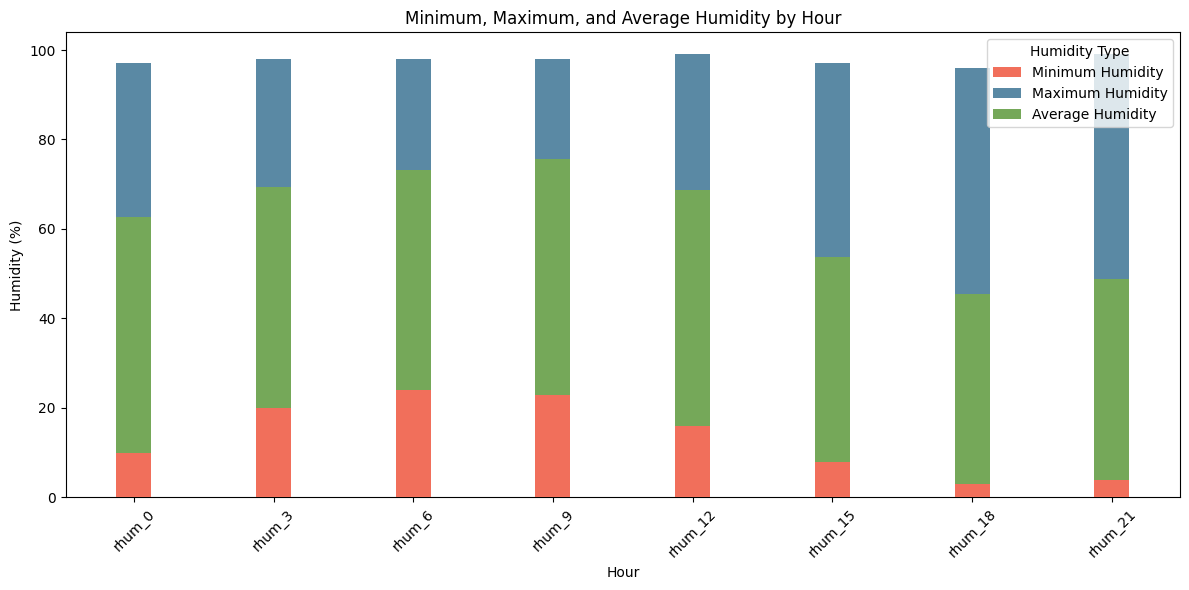

In [41]:
# List of humidity columns (replace these with your actual RHUM columns)
cols = ['rhum_0', 'rhum_3', 'rhum_6', 'rhum_9', 'rhum_12', 'rhum_15', 'rhum_18', 'rhum_21']

# Get the minimum, maximum, and average values for each RHUM column
min_values = df_pivoted[cols].min()
max_values = df_pivoted[cols].max()
avg_values = df_pivoted[cols].mean()

# Combine these values into a single DataFrame
humidity_values = pd.DataFrame({
    'Hour': min_values.index.tolist() * 3,
    'Humidity': pd.concat([min_values, max_values, avg_values], axis=0),
    'Type': ['Minimum Humidity'] * len(min_values) + ['Maximum Humidity'] * len(max_values) + ['Average Humidity'] * len(avg_values)
})

# Plot the result
plt.figure(figsize=(12, 6))

# Softer, more subdued colors for the humidity types
colors = {'Minimum Humidity': '#F16F5B', 'Maximum Humidity': '#5A89A4', 'Average Humidity': '#75A859'}

for label in humidity_values['Type'].unique():
    subset = humidity_values[humidity_values['Type'] == label]
    # Adjust zorder: minimum in front (highest), average in the middle, maximum behind (lowest)
    zorder = 3 if label == 'Minimum Humidity' else (2 if label == 'Average Humidity' else 1)
    plt.bar(subset['Hour'], subset['Humidity'], label=label, color=colors[label], width=0.25, align='center', zorder=zorder)

# Adding labels and title
plt.xlabel('Hour')
plt.ylabel('Humidity (%)')
plt.title('Minimum, Maximum, and Average Humidity by Hour')
plt.xticks(rotation=45)
plt.legend(title="Humidity Type")
plt.tight_layout()
plt.show()


Variation in precipitation for each month

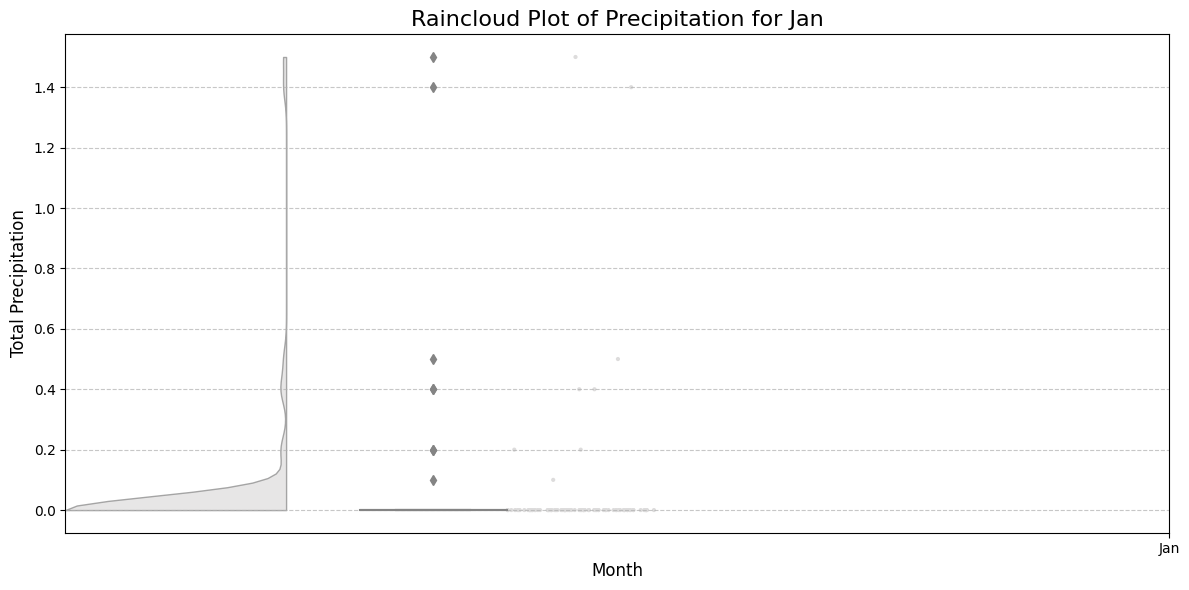

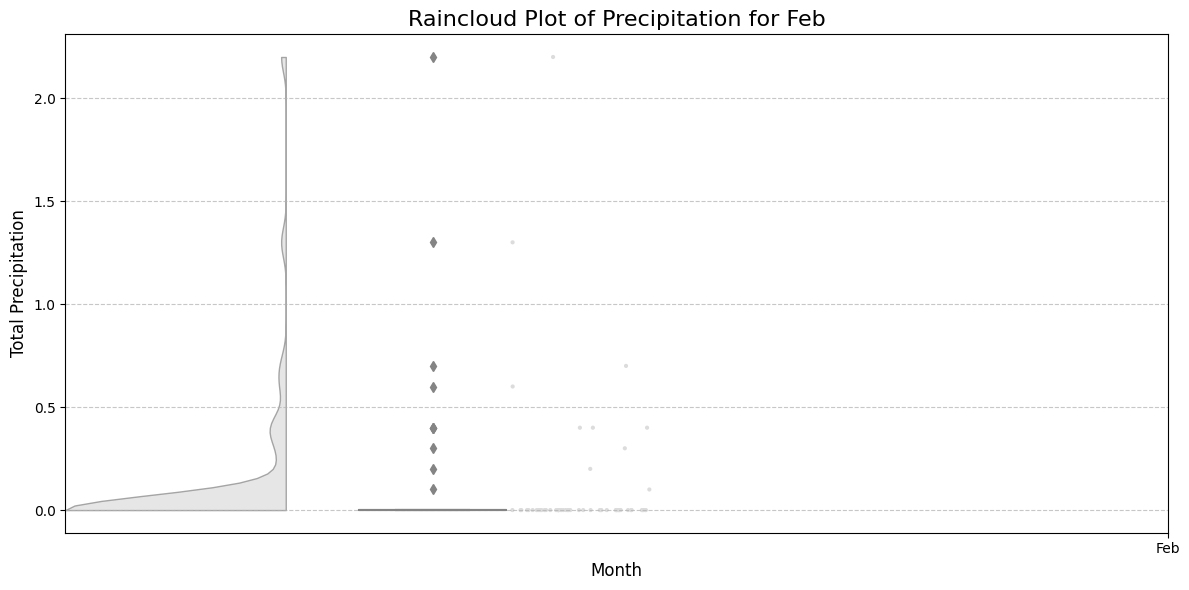

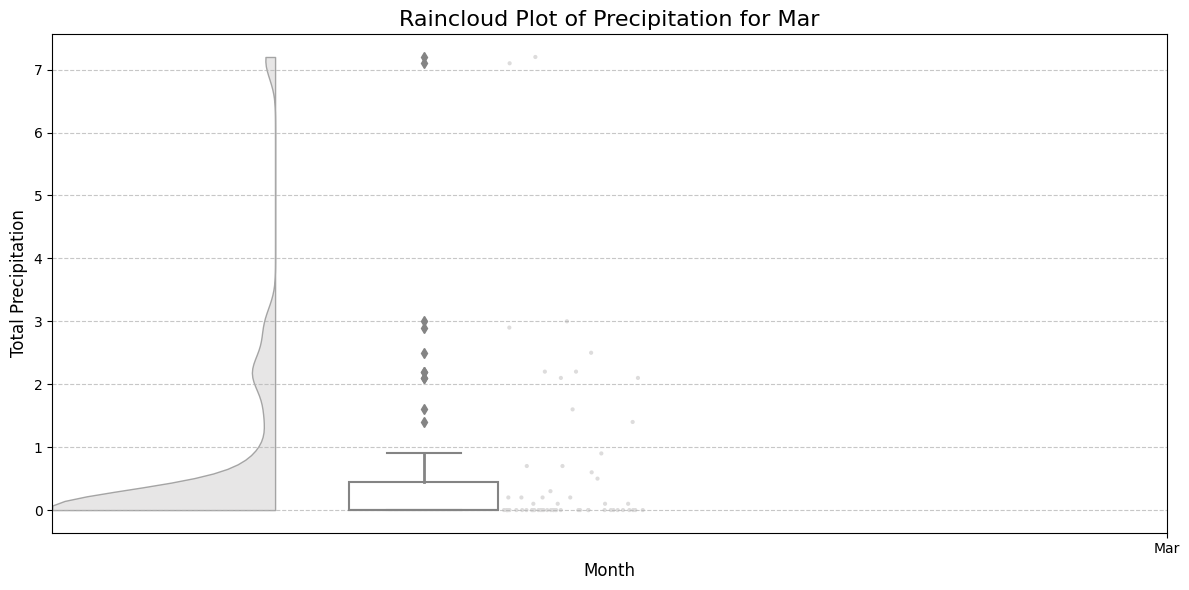

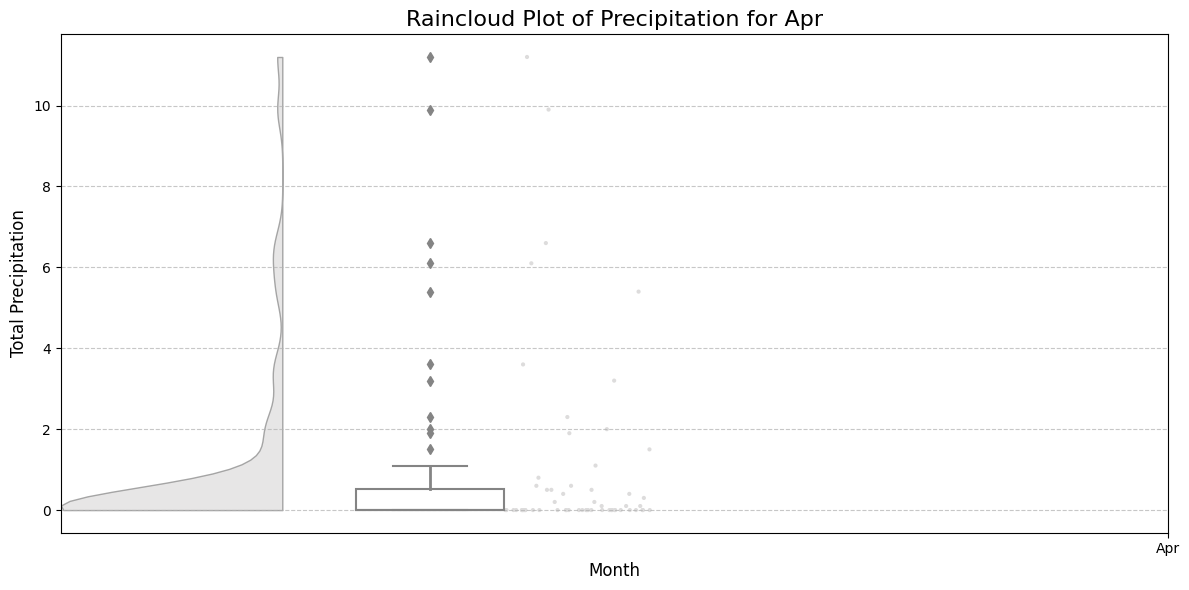

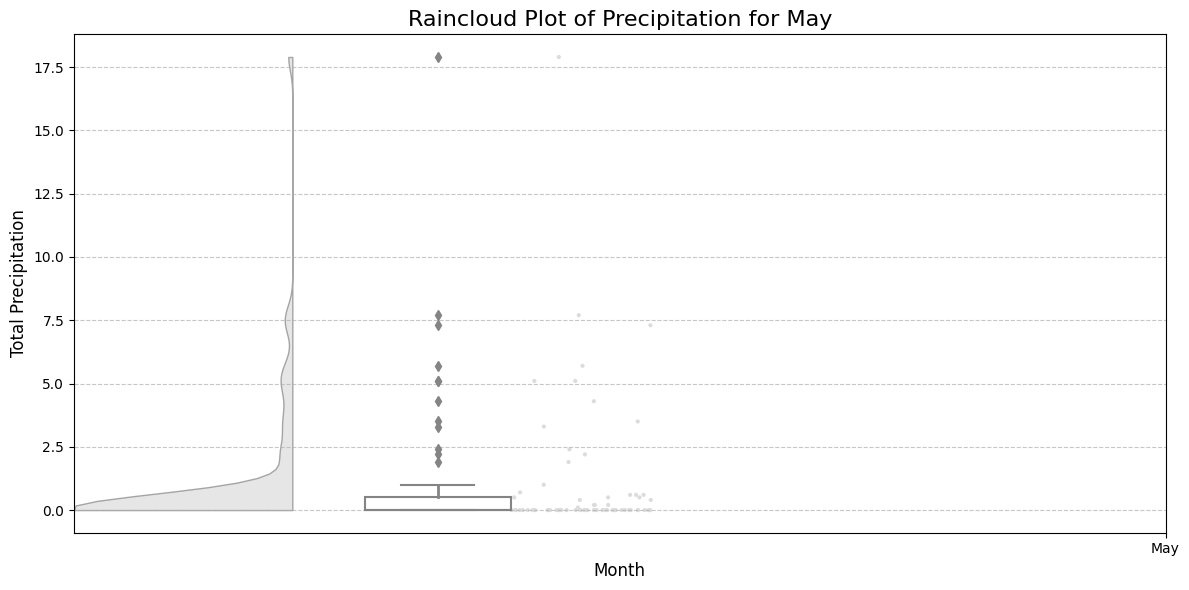

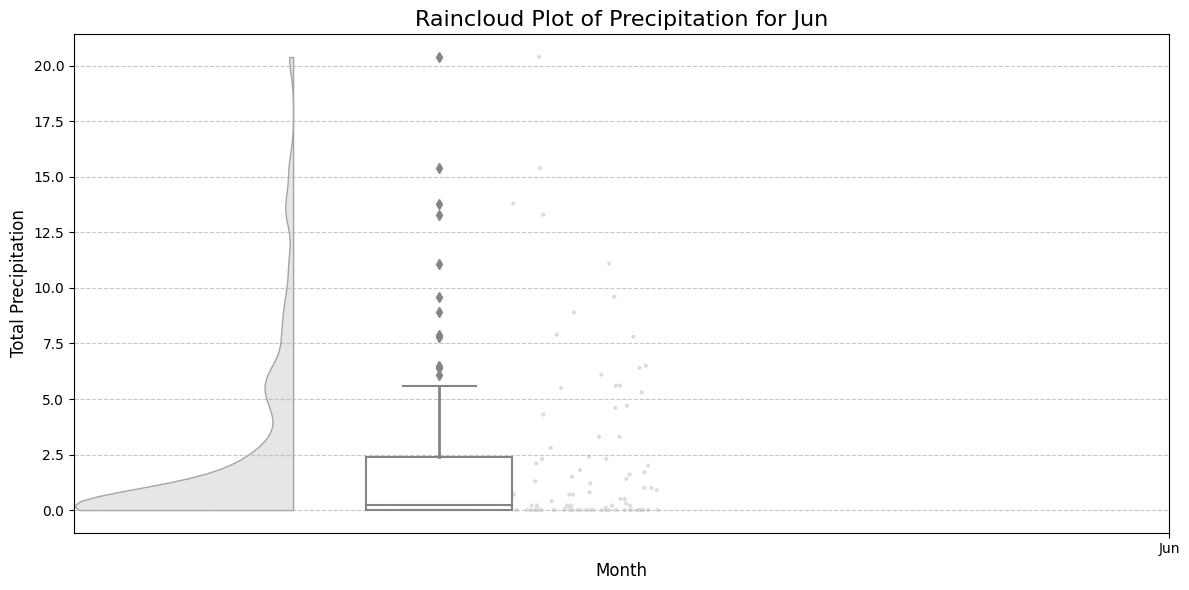

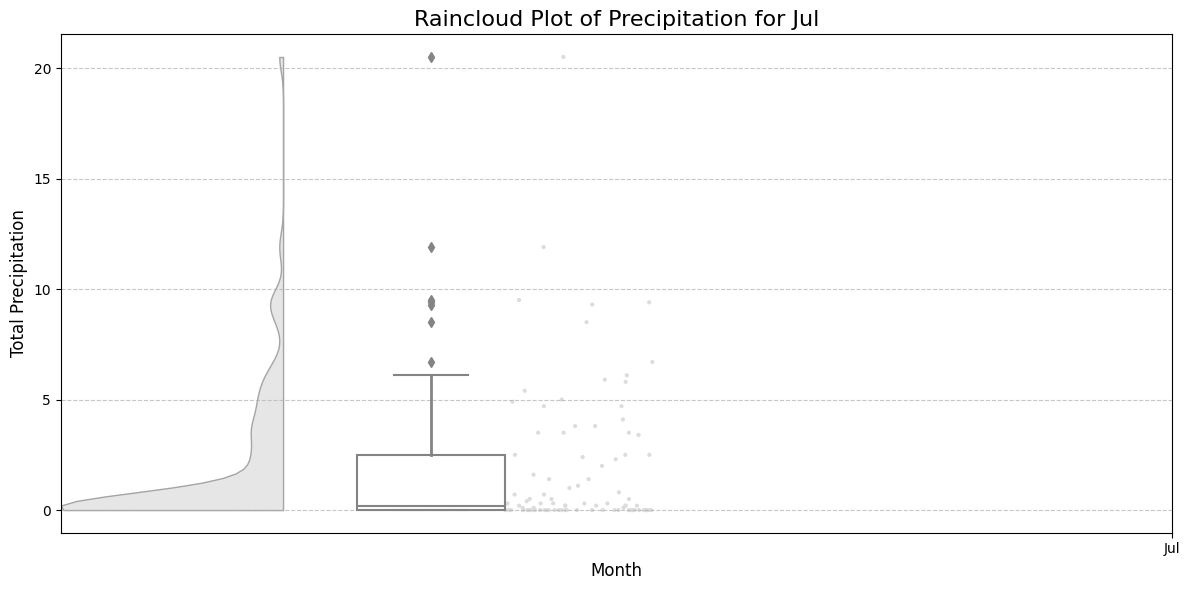

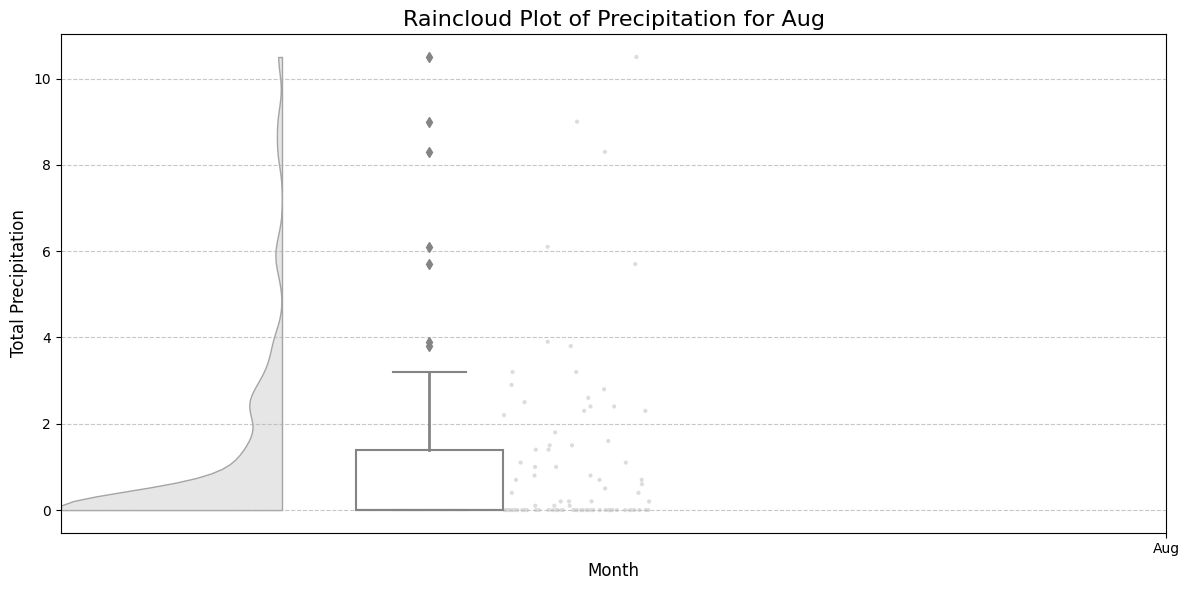

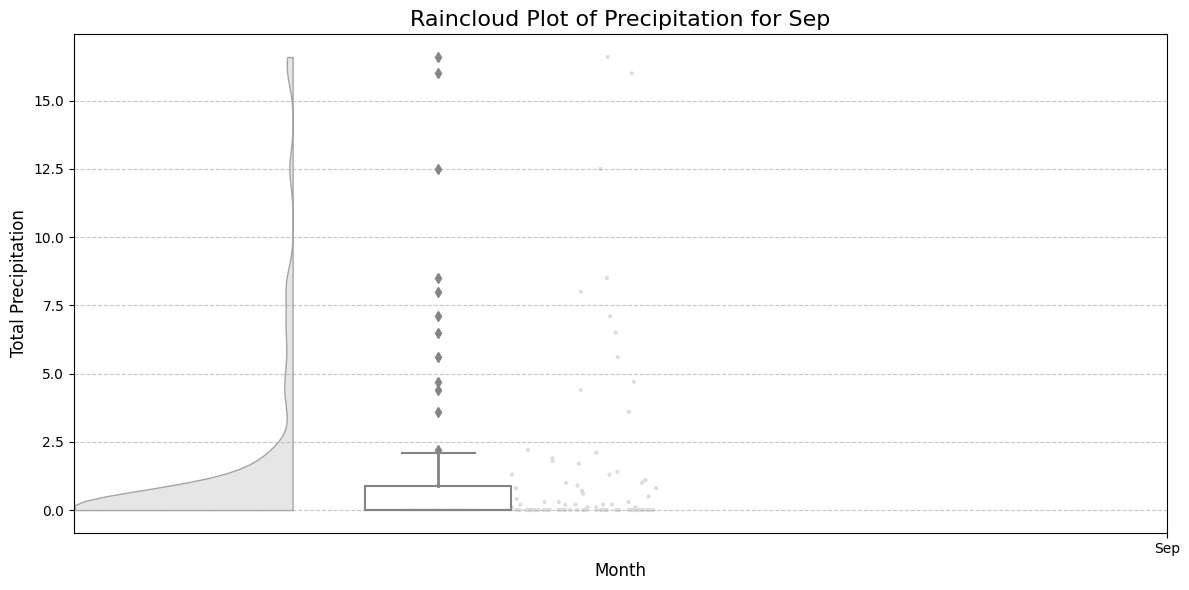

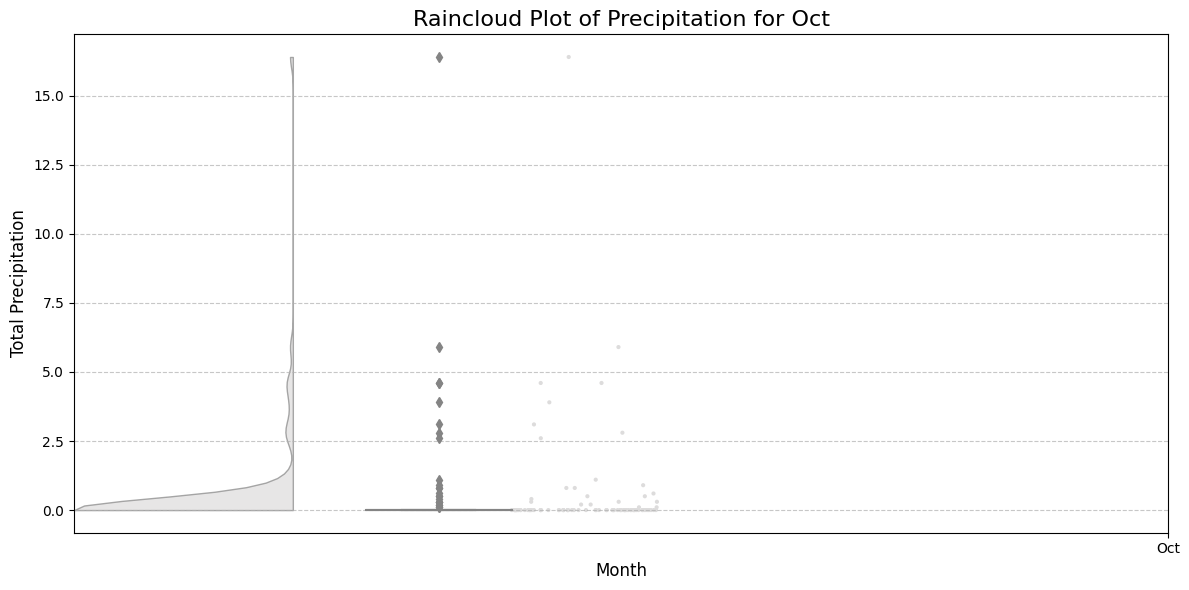

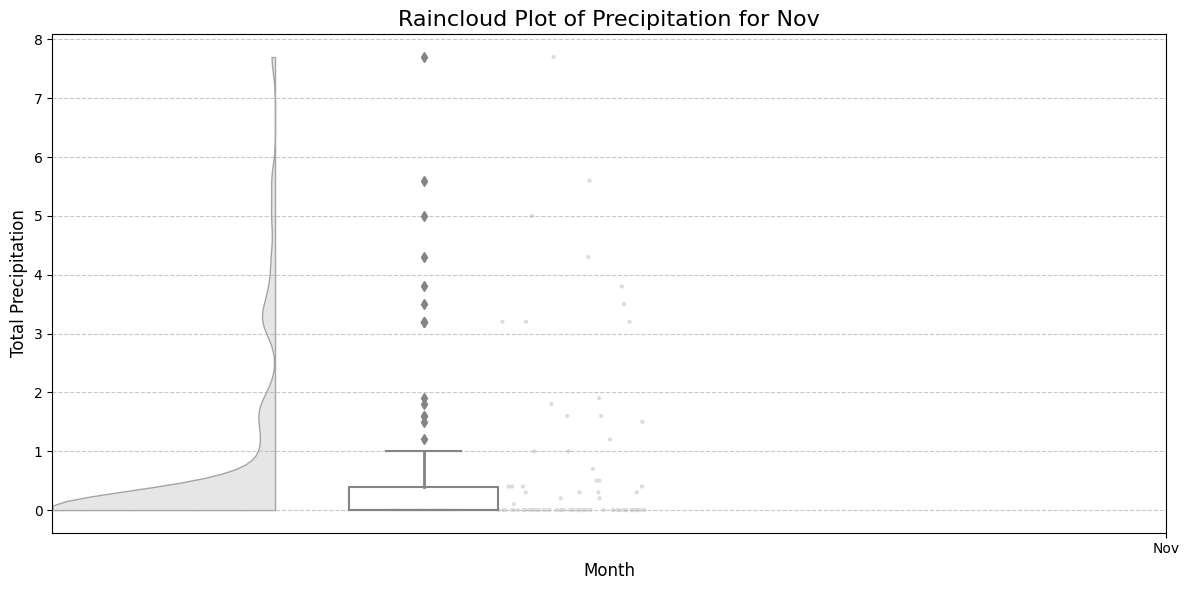

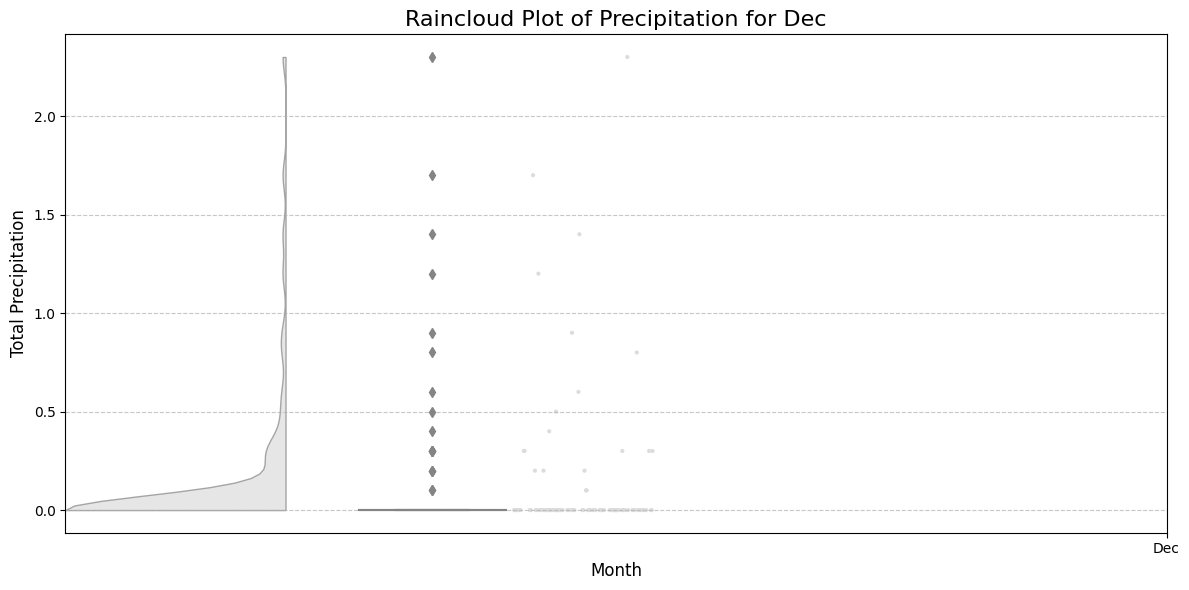

In [42]:

# Convert 'date' column to datetime if not already
df_pivoted['date'] = pd.to_datetime(df_pivoted['date'])

# Extract the month from the 'date' column
df_pivoted['month'] = df_pivoted['date'].dt.month

# Select 'prcp' columns and add the month column
prcp_columns = [col for col in df_pivoted.columns if col.startswith("prcp_")]
df_prcp = df_pivoted.loc[:, prcp_columns + ['month']]

# Sum the precipitation values for each row
df_prcp['Total Precipitation'] = df_prcp[prcp_columns].sum(axis=1)

# Create the plots for each month
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Plot each month separately
for month in range(1, 13):
    df_month = df_prcp[df_prcp['month'] == month]  # Filter data by month

    # Set up the raincloud plot for the current month
    plt.figure(figsize=(12, 6))
    pt.RainCloud(
        x="month",  # Month on x-axis
        y="Total Precipitation",  # Precipitation values on y-axis
        data=df_month,  # Filtered data for the current month
        palette="coolwarm",  # Color palette
        width_viol=0.6,  # Width of the violin plot
        width_box=0.2,  # Width of the boxplot
        alpha=0.7,  # Transparency
        move=0.2  # Overlap adjustment
    )

    # Add labels and title for the current month
    plt.title(f"Raincloud Plot of Precipitation for {month_labels[month-1]}", fontsize=16)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Total Precipitation", fontsize=12)
    plt.xticks(ticks=[1], labels=[month_labels[month-1]])  # Custom month label
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot for the current month
    plt.tight_layout()
    plt.show()


Accumulated Wind Direction(WDIR):

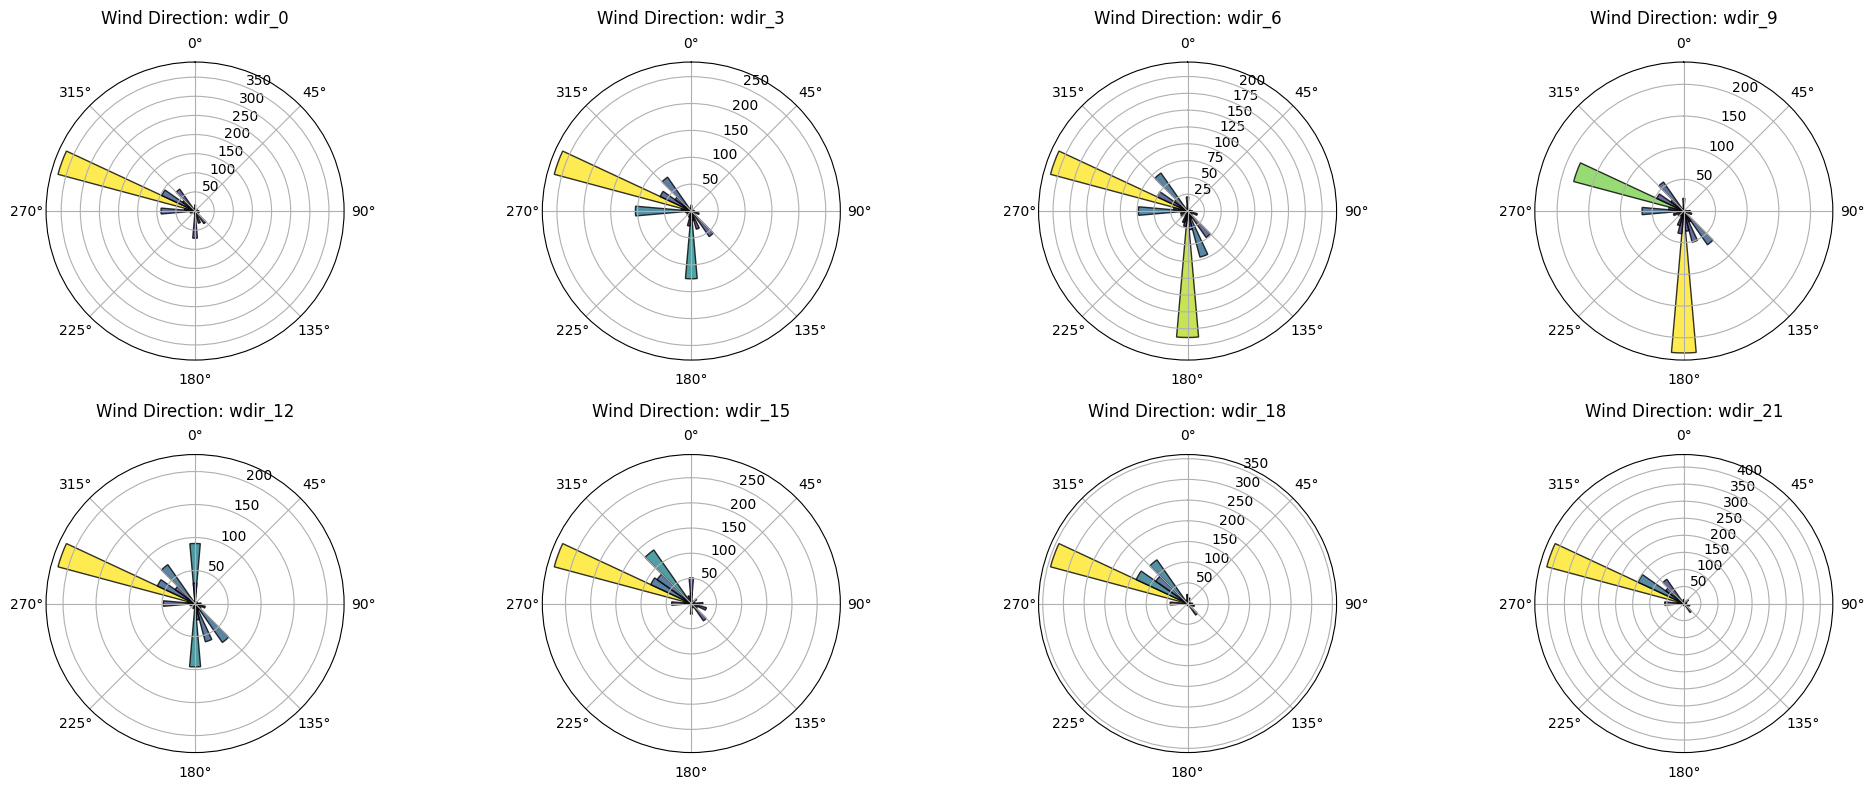

In [43]:

# Columns of interest
columns = ['wdir_0', 'wdir_3', 'wdir_6', 'wdir_9', 'wdir_12', 'wdir_15', 'wdir_18', 'wdir_21']

# Determine layout for subplots
n_cols = 4  # Number of columns per row
n_rows = int(np.ceil(len(columns) / n_cols))  # Number of rows

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8), subplot_kw={'projection': 'polar'})

# Flatten axes array for easier indexing
axes = axes.flatten()

for i, col in enumerate(columns):
    # Calculate the frequency of each wind direction
    counts = df_pivoted[col].value_counts().sort_index()  # Count sorted by degrees
    angles = np.deg2rad(counts.index)  # Convert degrees to radians

    # Normalize counts for colormap
    normalized_values = counts.values / counts.values.max()

    # Create the radial plot with a color gradient
    colors = cm.viridis(normalized_values)  # Using the Viridis colormap
    bars = axes[i].bar(angles, counts.values, width=np.deg2rad(10), color=colors, edgecolor='black', alpha=0.8)

    # Set the title for each subplot
    axes[i].set_title(f"Wind Direction: {col}", va='bottom')

    # Adjust to set 0° (North) at the top
    axes[i].set_theta_zero_location('N')
    axes[i].set_theta_direction(-1)

# Remove empty subplots if any
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

Wind Speed(wspd) Distribution by Year

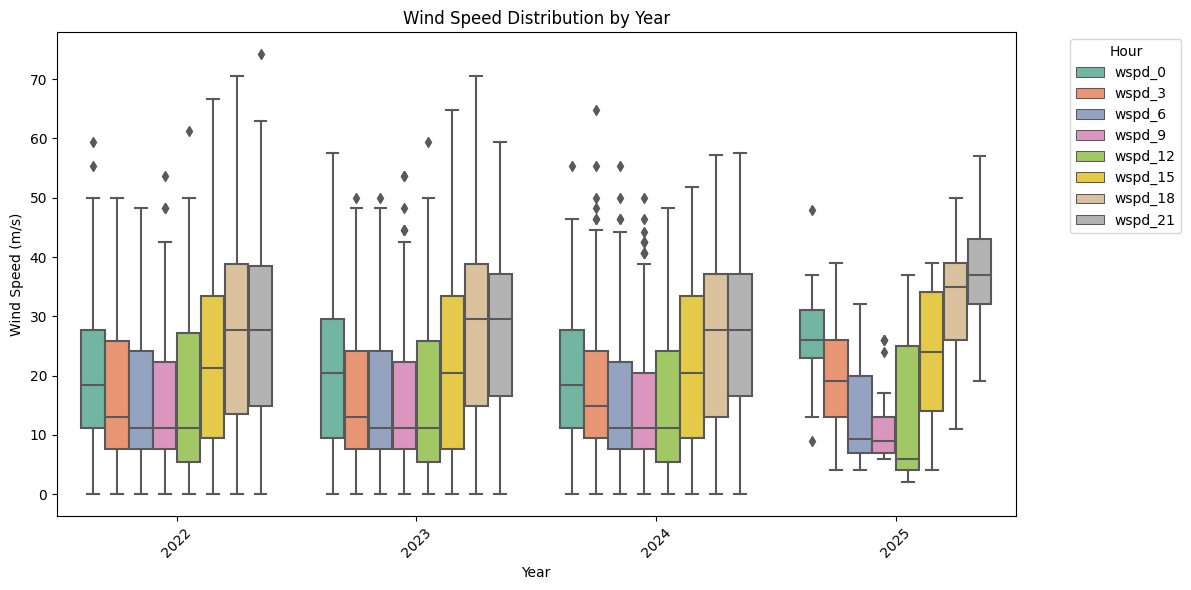

In [44]:
# List of wind speed columns (replace these with your actual wspd columns)
wspd_cols = ['wspd_0', 'wspd_3', 'wspd_6', 'wspd_9', 'wspd_12', 'wspd_15', 'wspd_18', 'wspd_21']

# Extract the year from the 'date' column
df_pivoted['Year'] = pd.to_datetime(df_pivoted['date']).dt.year

# Melt the DataFrame so that the wind speed columns are stacked
df_melted = df_pivoted.melt(id_vars=['Year'], value_vars=wspd_cols,
                            var_name='Hour', value_name='Wind Speed')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Year', y='Wind Speed', hue='Hour', palette='Set2')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Distribution by Year')
plt.xticks(rotation=45)
plt.legend(title="Hour", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Pressure(pres) Timeline by Hour

In [45]:
# List of pressure columns (replace these with your actual pres columns)
pres_cols = ['pres_0', 'pres_3', 'pres_6', 'pres_9', 'pres_12', 'pres_15', 'pres_18', 'pres_21']

# Convert the 'date' column to datetime if it's not already in datetime format
df_pivoted['date'] = pd.to_datetime(df_pivoted['date'])

# Melt the DataFrame so that the pressure columns are stacked
df_melted_pres = df_pivoted.melt(id_vars=['date'], value_vars=pres_cols,
                                 var_name='Hour', value_name='Pressure')

# Create the Plotly line plot
fig = px.line(df_melted_pres, x='date', y='Pressure', color='Hour',
              labels={'Pressure': 'Pressure (hPa)', 'date': 'Date', 'Hour': 'Hour of the Day'},
              title='Pressure Timeline by Hour')

# Show the plot
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Pressure (hPa)',
    legend_title='Hour',
    autosize=True
)

fig.show()


Weather Condition(coco)

In [46]:
# Flatten all 'coco_*' columns into a single column
coco_values = df_pivoted.filter(like='coco').stack().reset_index(drop=True)

# Count the frequency of each value
frequency_df = coco_values.value_counts().reset_index()
frequency_df.columns = ['Code', 'Frequency']

# Merge the frequency DataFrame with the weather condition names
merged_df = pd.merge(frequency_df, weather_condition_df, on='Code', how='left')

# Plot the frequency of each weather condition and add text annotations for the frequency
fig = px.bar(merged_df, x='Weather Condition', y='Frequency',
             labels={'Weather Condition': 'Weather Condition', 'Frequency': 'Frequency'},
             title='Frequency of Weather Conditions')

# Add frequency value on top of each bar
fig.update_traces(text=merged_df['Frequency'], textposition='outside', texttemplate='%{text}')

# Show the plot
fig.show()

Accumulated days with and without rain:

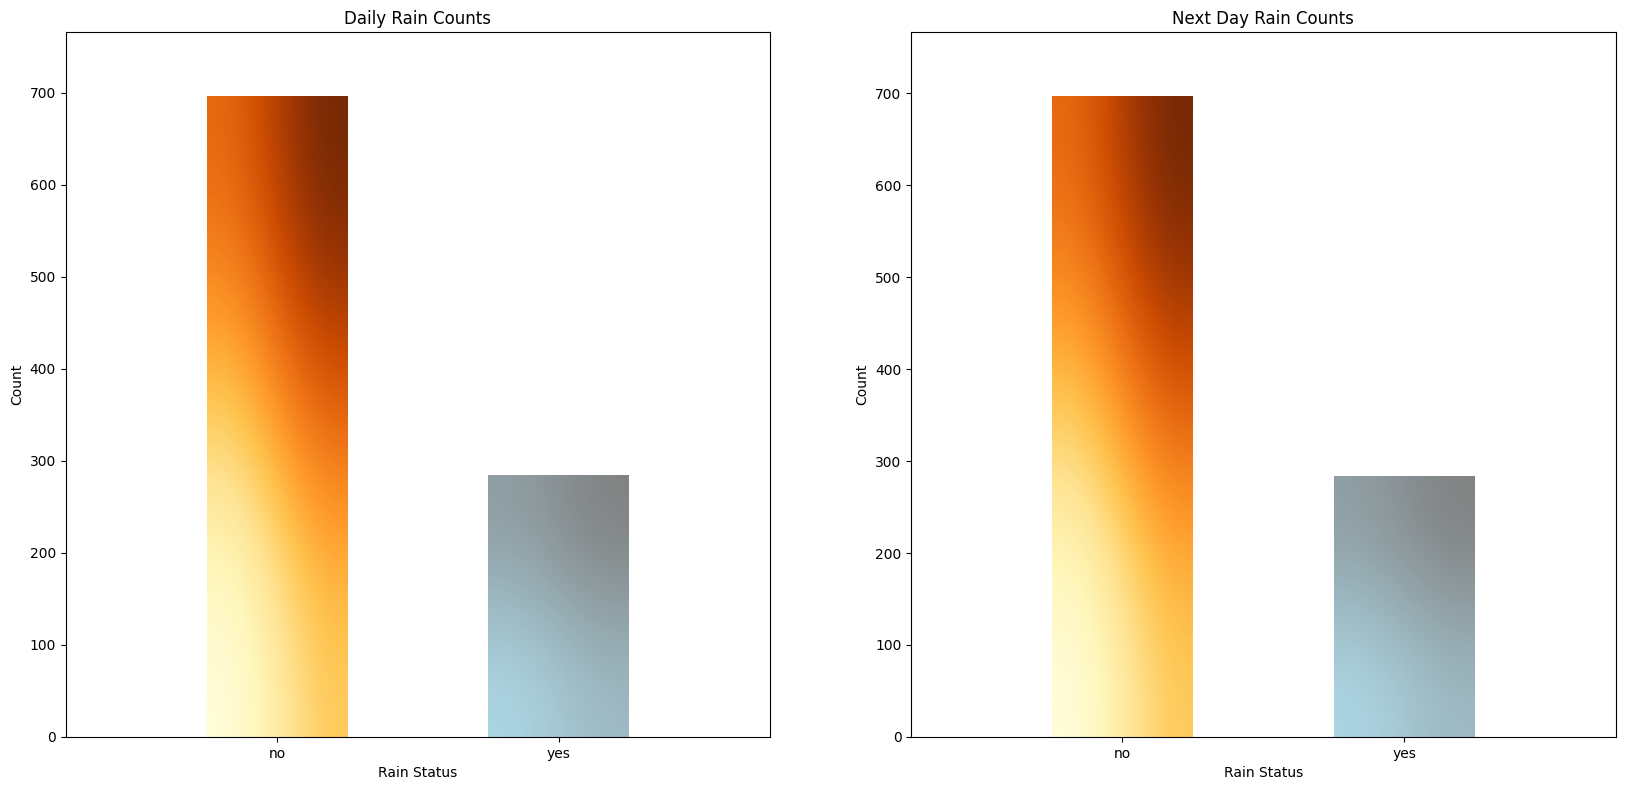

In [47]:
def gradient_image(ax, extent, direction=0.3, cmap_range=(0, 1), **kwargs):
    phi = direction * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, extent=extent, interpolation='bicubic',
                   vmin=0, vmax=1, **kwargs)
    return im


def gradient_bar(ax, counts, labels, x_limits, y_max, bar_width=0.5, margin=0.2):
    # Adjust the effective range limits for the bars
    effective_range = (1 - 2 * margin) * (x_limits[1] - x_limits[0])
    center_offset = margin * (x_limits[1] - x_limits[0])
    new_x_limits = (x_limits[0] + center_offset, x_limits[1] - center_offset)

    # Calculate bar positions within the effective range
    num_bars = len(counts)
    x_positions = np.linspace(new_x_limits[0] + bar_width / 2, new_x_limits[1] - bar_width / 2, num_bars)

    # Custom colormap for 'yes' (light blue to gray)
    light_blue_to_gray = mcolors.LinearSegmentedColormap.from_list('light_blue_gray', ['#add8e6', 'gray'])  # Light blue to gray

    # Draw the gradient bars
    for left, top, label, pos in zip(x_positions - bar_width / 2, counts, labels, x_positions):
        right = left + bar_width

        # Choose the colormap based on the label
        if label == 'yes':
            cmap = light_blue_to_gray  # Custom gradient for "yes" (light blue to gray)
            cmap_range = (0, 1)
        else:
            cmap = plt.cm.YlOrBr  # Yellow gradient for "no"
            cmap_range = (0, 1)

        gradient_image(ax, extent=(left, right, 0, top), cmap=cmap, cmap_range=cmap_range)


    return x_positions

# Create the subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Get counts for each value
daily_rain_counts = df_pivoted['daily_rain'].value_counts()
next_day_rain_counts = df_pivoted['next_day_rain'].value_counts()

# Extract labels and values
daily_rain_labels = daily_rain_counts.index.tolist()
next_day_rain_labels = next_day_rain_counts.index.tolist()

# Calculate axis limits
y_limit_max_daily = daily_rain_counts.max() * 1.1
y_limit_max_next_day = next_day_rain_counts.max() * 1.1

x_limit_daily = (-y_limit_max_daily / 2, y_limit_max_daily / 2)
x_limit_next_day = (-y_limit_max_next_day / 2, y_limit_max_next_day / 2)

# Draw bars for 'daily_rain'
x_positions_daily = gradient_bar(ax[0], daily_rain_counts.values, daily_rain_labels, x_limit_daily, y_limit_max_daily, bar_width=0.2 * y_limit_max_daily, margin=0.2)

# Draw bars for 'next_day_rain'
x_positions_next_day = gradient_bar(ax[1], next_day_rain_counts.values, next_day_rain_labels, x_limit_next_day, y_limit_max_next_day, bar_width=0.2 * y_limit_max_next_day, margin=0.2)

# Configure the plots
ax[0].set_title('Daily Rain Counts')
ax[0].set_xticks(x_positions_daily)  # Use the central positions of the bars
ax[0].set_xticklabels(daily_rain_labels)
ax[0].set_xlabel('Rain Status')
ax[0].set_ylabel('Count')
ax[0].set_ylim(0, y_limit_max_daily)
ax[0].set_xlim(x_limit_daily)

ax[1].set_title('Next Day Rain Counts')
ax[1].set_xticks(x_positions_next_day)  # Use the central positions of the bars
ax[1].set_xticklabels(next_day_rain_labels)
ax[1].set_xlabel('Rain Status')
ax[1].set_ylabel('Count')
ax[1].set_ylim(0, y_limit_max_next_day)
ax[1].set_xlim(x_limit_next_day)



# Show the plot
plt.show()



Correlation between all numerical variables

In [48]:



# Select only numerical columns
numerical_columns = df_pivoted.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,        # Values of the correlation matrix
    x=correlation_matrix.columns,       # X-axis (column names)
    y=correlation_matrix.columns,       # Y-axis (column names)
    colorscale='RdBu',                  # Color scale
    colorbar=dict(title="Correlation"), # Colorbar title
    zmin=-1, zmax=1                     # Color scale range
))

# Update the layout
fig.update_layout(
    title='Correlation Matrix Heatmap',
    xaxis=dict(
        title='Variables',
        tickangle=-45,         # Rotate x-axis labels to prevent overlap
        tickmode='array',
        tickvals=list(correlation_matrix.columns)
    ),
    yaxis=dict(
        title='Variables',
        tickmode='array',
        tickvals=list(correlation_matrix.columns)
    ),
    template='plotly_dark',             # Dark theme
    autosize=True,
    height=1200,                         # Increase the height for better spacing
    width=1200                           # Adjust the width if necessary
)

# Show the plot
fig.show()



# Modelado

# Clasification

In [49]:
df_pivoted

,date,temp_0,temp_3,temp_6,temp_9,temp_12,temp_15,temp_18,temp_21,dwpt_0,...,coco_9,coco_12,coco_15,coco_18,coco_21,daily_precipitation,daily_rain,next_day_rain,month,Year
0,2022-05-24,2.7,1.6,3.2,2.8,2.3,1.4,3.3,3.1,0.3,...,7.0,8.0,8.0,8.0,7.0,4.2,yes,yes,5,2022
1,2022-05-25,2.4,1.3,-1.9,-3.6,-5.0,-0.4,3.1,3.6,0.5,...,2.0,2.0,2.0,2.0,2.0,0.0,no,no,5,2022
2,2022-05-26,-2.0,-5.2,-6.8,-8.1,-5.9,-1.7,1.0,0.5,-4.7,...,1.0,2.0,2.0,2.0,2.0,0.0,no,no,5,2022
3,2022-05-27,-3.1,-4.8,-6.8,-4.4,-3.7,-0.9,1.7,2.7,-5.3,...,1.0,2.0,2.0,2.0,2.0,0.0,no,no,5,2022
4,2022-05-28,-2.4,-4.2,-5.4,-7.5,-6.1,-0.4,3.7,2.4,-5.5,...,2.0,2.0,3.0,2.0,2.0,0.0,no,no,5,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,2025-01-23,19.0,16.0,15.0,13.0,15.0,18.0,17.0,15.0,1.9,...,4.0,3.0,3.0,2.0,3.0,1.7,yes,yes,1,2025
976,2025-01-24,13.0,12.0,11.0,10.0,13.0,16.0,18.0,19.0,3.9,...,3.0,2.0,3.0,3.0,2.0,0.0,no,no,1,2025
977,2025-01-25,15.0,11.0,4.0,3.0,12.0,18.0,24.0,26.0,4.9,...,1.0,1.0,1.0,1.0,1.0,0.0,no,no,1,2025
978,2025-01-26,21.0,17.0,11.0,8.0,16.0,25.0,25.0,21.0,6.9,...,1.0,1.0,1.0,1.0,1.0,0.0,no,no,1,2025


In [50]:
#nombres de las columnas
df_pivoted.columns

Index(['date', 'temp_0', 'temp_3', 'temp_6', 'temp_9', 'temp_12', 'temp_15',
       'temp_18', 'temp_21', 'dwpt_0', 'dwpt_3', 'dwpt_6', 'dwpt_9', 'dwpt_12',
       'dwpt_15', 'dwpt_18', 'dwpt_21', 'rhum_0', 'rhum_3', 'rhum_6', 'rhum_9',
       'rhum_12', 'rhum_15', 'rhum_18', 'rhum_21', 'prcp_0', 'prcp_3',
       'prcp_6', 'prcp_9', 'prcp_12', 'prcp_15', 'prcp_18', 'prcp_21',
       'wdir_0', 'wdir_3', 'wdir_6', 'wdir_9', 'wdir_12', 'wdir_15', 'wdir_18',
       'wdir_21', 'wspd_0', 'wspd_3', 'wspd_6', 'wspd_9', 'wspd_12', 'wspd_15',
       'wspd_18', 'wspd_21', 'pres_0', 'pres_3', 'pres_6', 'pres_9', 'pres_12',
       'pres_15', 'pres_18', 'pres_21', 'coco_0', 'coco_3', 'coco_6', 'coco_9',
       'coco_12', 'coco_15', 'coco_18', 'coco_21', 'daily_precipitation',
       'daily_rain', 'next_day_rain', 'month', 'Year'],
      dtype='object')

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Identify columns with datetime values
datetime_columns = df_pivoted.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns

# Convert datetime columns to numeric features (e.g., year, month, day)
for col in datetime_columns:
    df_pivoted[f'{col}_year'] = df_pivoted[col].dt.year
    df_pivoted[f'{col}_month'] = df_pivoted[col].dt.month
    df_pivoted[f'{col}_day'] = df_pivoted[col].dt.day
    # Optionally drop the original datetime column if not needed
    df_pivoted = df_pivoted.drop(columns=[col])

# Separate features (X) and target (y)
X = df_pivoted.iloc[:-1].drop(columns=['next_day_rain'])  # Exclude target column and last row
y = df_pivoted.iloc[:-1]['next_day_rain']


# Convert the target column ('next_day_rain') to numeric (1 for 'yes', 0 for 'no')
df_pivoted['next_day_rain'] = df_pivoted['next_day_rain'].map({'yes': 1, 'no': 0})

# Identify categorical columns in features
categorical_columns = df_pivoted.select_dtypes(include=['object']).columns

# Convert categorical features to numeric using LabelEncoder
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_pivoted[col] = le.fit_transform(df_pivoted[col])
    label_encoders[col] = le  # Save the encoder for potential inverse transformation later

# Separate features (X) and target (y)
X = df_pivoted.iloc[:-1].drop(columns=['next_day_rain'])  # Exclude target column and last row
y = df_pivoted.iloc[:-1]['next_day_rain']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Define the parameter grid for the Random Forest classifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available processors
    verbose=2
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Use the best model to predict on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.997452229299363

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       130
           1       1.00      0.98      0.99        66

    accuracy                           0.99       196
   macro avg       1.00      0.99      0.99       196
weighted avg       0.99      0.99      0.99       196



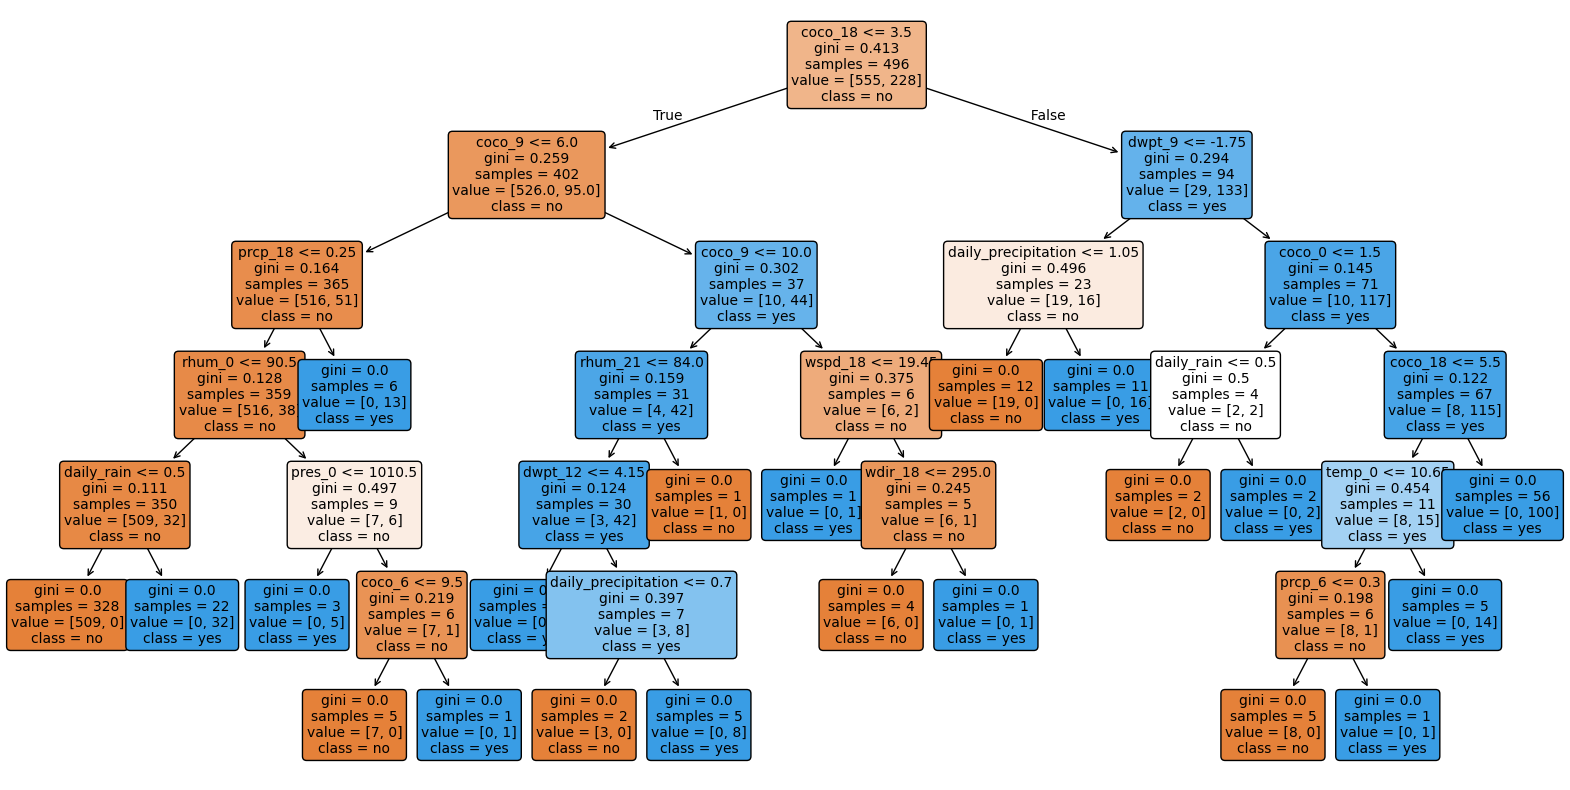

In [54]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Extract a single tree from the Random Forest (directly from the trained model)
tree_to_plot = clf.estimators_[0]  # Seleccionar el primer árbol (puedes cambiar el índice)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot,
          feature_names=X_train.columns,  # Nombres de las columnas
          class_names=['no', 'yes'],  # Clases
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()


In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define el modelo
gbc = GradientBoostingClassifier(random_state=42)

# Define el grid de hiperparámetros para optimización
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1
)

# Entrena el modelo con los mejores parámetros
grid_search.fit(X_train, y_train)

# Evaluar el modelo
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

y_pred = grid_search.best_estimator_.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.997452229299363

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       130
           1       1.00      0.95      0.98        66

    accuracy                           0.98       196
   macro avg       0.99      0.98      0.98       196
weighted avg       0.99      0.98      0.98       196



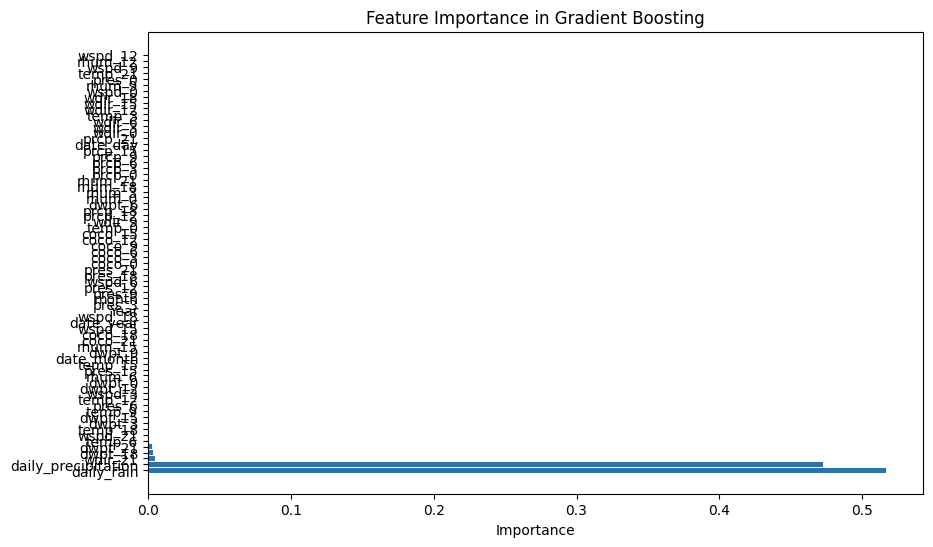

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener la importancia de las características
feature_importance = grid_search.best_estimator_.feature_importances_

# Crear un DataFrame con los resultados
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Gradient Boosting')
plt.show()

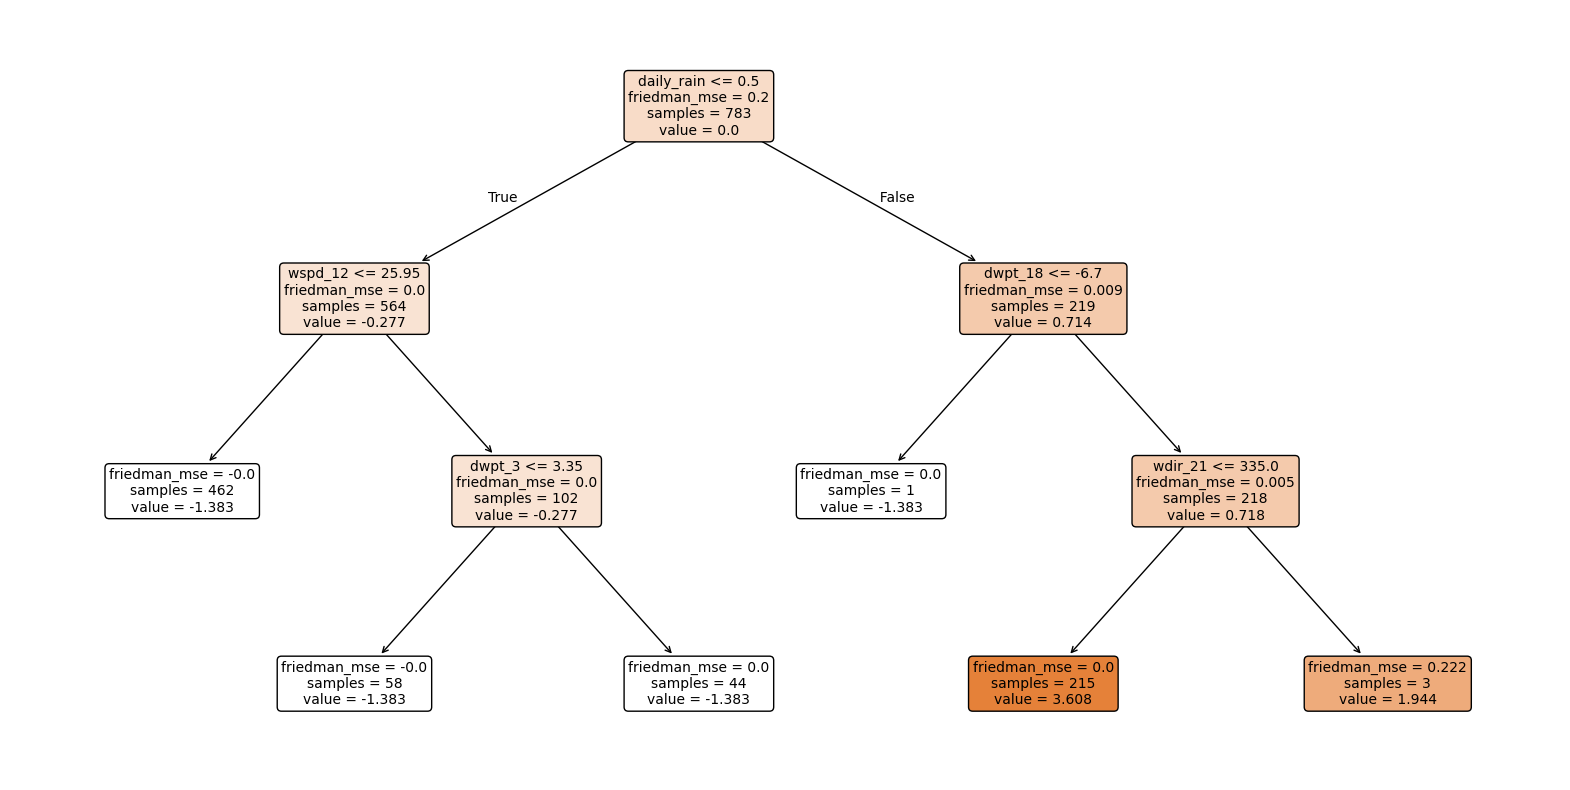

In [58]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Obtener el primer árbol en el modelo de Gradient Boosting
# Aquí estamos extrayendo un árbol de los estimadores del modelo
tree_to_plot = grid_search.best_estimator_.estimators_[0][0]

# Graficar el árbol
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot,
          feature_names=X_train.columns,
          class_names=['no', 'yes'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()


In [59]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dividir el DataFrame en características (X) y objetivo (y)
X = df_pivoted.drop('next_day_rain', axis=1)  # Asegúrate de excluir la columna objetivo
y = df_pivoted['next_day_rain']

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir los valores de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        71

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196



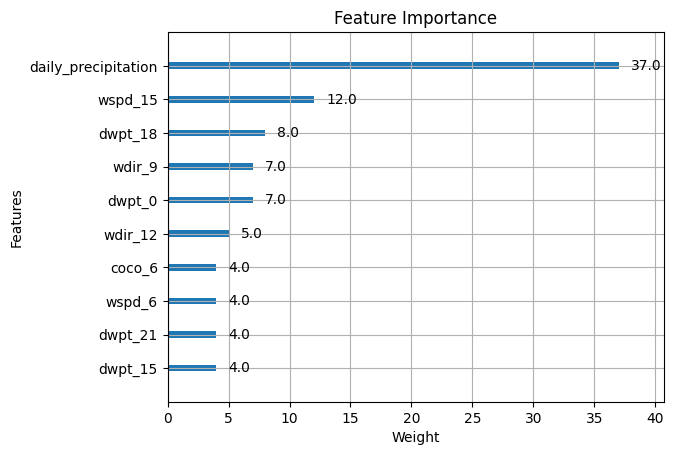

In [60]:
import matplotlib.pyplot as plt

# Visualizar la importancia de las características
xgb.plot_importance(model, importance_type='weight', max_num_features=10, title="Feature Importance", xlabel="Weight", ylabel="Features")

# Mostrar el gráfico
plt.show()

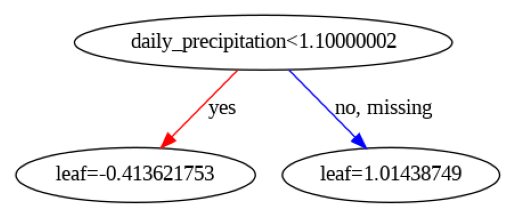

<Figure size 2000x1000 with 0 Axes>

In [61]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Graficar el primer árbol del modelo XGBoost
xgb.plot_tree(model, num_trees=0)  # num_trees=0 para graficar el primer árbol

# Ajustar tamaño del gráfico
plt.figure(figsize=(20, 10))

# Mostrar el gráfico
plt.show()


# Prediction

In [62]:
df_pivoted = df_pivoted.drop(columns=['daily_rain', 'next_day_rain'])

In [63]:
# Define the features (X) and target variable (y)
X = df_pivoted.drop(columns=['daily_precipitation'])  # Features (without the target column)
y = df_pivoted['daily_precipitation']  # Target variable (daily_precipitation)


In [64]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train a Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R2: {r2_rf}")

Random Forest MSE: 9.321667454081636
Random Forest R2: 0.8456665973845138


In [78]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost (regression)
params = {
    'objective': 'reg:squarederror',  # Mean squared error
    'eval_metric': 'rmse',  # Root mean squared error
}

# Train the XGBoost model
xgb_regressor = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_xgb = xgb_regressor.predict(dtest)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the evaluation metrics
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost R2: {r2_xgb}")


XGBoost MSE: 15.23791026850303
XGBoost R2: 0.7477148211870834


In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Create a pipeline with StandardScaler and LinearRegression
pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Define the parameter grid
param_grid = {
    'linearregression__fit_intercept': [True, False]  # 'linearregression__' prefix for pipeline
}

# Set up GridSearchCV
grid_search_lr = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the data
grid_search_lr.fit(X_train, y_train)

# Get the best parameters
best_params_lr = grid_search_lr.best_params_

# Get the best model
best_lr_model = grid_search_lr.best_estimator_

# Print the best parameters
print(f"Best Parameters for Linear Regression: {best_params_lr}")

# Evaluate the model
y_pred_lr = best_lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R2: {r2_lr}")



Best Parameters for Linear Regression: {'linearregression__fit_intercept': True}
Linear Regression MSE: 1.1480464376600497
Linear Regression R2: 0.9809924657838892


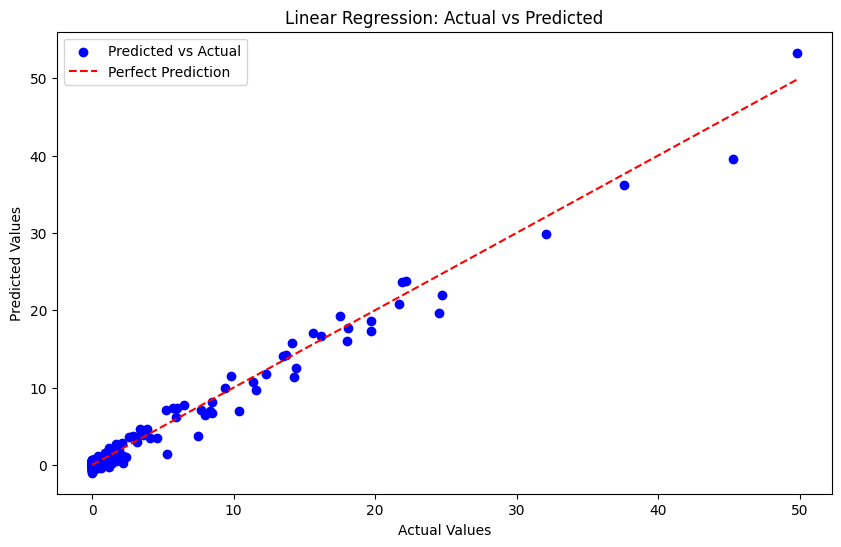

Linear Regression MSE: 1.148046437660082
Linear Regression R2: 0.9809924657838887


In [79]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train a simple Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = model_lr.predict(X_test)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_lr, color='blue', label='Predicted vs Actual')

# Plot the line of perfect prediction (diagonal line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Optionally, print metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R2: {r2_lr}")


In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define el modelo
model_dt = DecisionTreeRegressor(random_state=42)

# Define los parámetros para la búsqueda
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# GridSearchCV para encontrar los mejores parámetros
grid_search_dt = GridSearchCV(model_dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error')
grid_search_dt.fit(X_train, y_train)

# Mejor modelo
print("Mejores parámetros para Decision Tree:", grid_search_dt.best_params_)

# Predicción y evaluación
y_pred_dt = grid_search_dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree MSE: {mse_dt}")
print(f"Decision Tree R2: {r2_dt}")



Mejores parámetros para Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Decision Tree MSE: 18.008120346669465
Decision Tree R2: 0.7018500711915305


In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define el modelo
model_rf = RandomForestRegressor(random_state=42)

# Define los parámetros para la búsqueda
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV para encontrar los mejores parámetros
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

# Mejor modelo
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)

# Predicción y evaluación
y_pred_rf = grid_search_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R2: {r2_rf}")


Mejores parámetros para Random Forest: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest MSE: 10.23948821935783
Random Forest R2: 0.8304707751355447


In [83]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define el modelo
model_gb = GradientBoostingRegressor(random_state=42)

# Define los parámetros para la búsqueda
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}

# GridSearchCV para encontrar los mejores parámetros
grid_search_gb = GridSearchCV(model_gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)

# Mejor modelo
print("Mejores parámetros para Gradient Boosting:", grid_search_gb.best_params_)

# Predicción y evaluación
y_pred_gb = grid_search_gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting MSE: {mse_gb}")
print(f"Gradient Boosting R2: {r2_gb}")


Mejores parámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Gradient Boosting MSE: 6.526087332052673
Gradient Boosting R2: 0.8919513843759258


In [85]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define el modelo
model_svr = SVR()

# Define los parámetros para la búsqueda
param_grid_svr = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
}

# GridSearchCV para encontrar los mejores parámetros
grid_search_svr = GridSearchCV(model_svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train, y_train)

# Mejor modelo
print("Mejores parámetros para SVR:", grid_search_svr.best_params_)

# Predicción y evaluación
y_pred_svr = grid_search_svr.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR MSE: {mse_svr}")
print(f"SVR R2: {r2_svr}")


Mejores parámetros para SVR: {'C': 100, 'epsilon': 0.2, 'kernel': 'poly'}
SVR MSE: 52.27890434040327
SVR R2: 0.1344487205096464


In [86]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Define el modelo
model_knn = KNeighborsRegressor()

# Define los parámetros para la búsqueda
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

# GridSearchCV para encontrar los mejores parámetros
grid_search_knn = GridSearchCV(model_knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train, y_train)

# Mejor modelo
print("Mejores parámetros para KNN:", grid_search_knn.best_params_)

# Predicción y evaluación
y_pred_knn = grid_search_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN MSE: {mse_knn}")
print(f"KNN R2: {r2_knn}")


Mejores parámetros para KNN: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
KNN MSE: 43.136028290569534
KNN R2: 0.2858219782892538


In [87]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Define el modelo
model_nn = MLPRegressor(max_iter=1000, random_state=42)

# Define los parámetros para la búsqueda
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}

# GridSearchCV para encontrar los mejores parámetros
grid_search_nn = GridSearchCV(model_nn, param_grid_nn, cv=5, scoring='neg_mean_squared_error')
grid_search_nn.fit(X_train, y_train)

# Mejor modelo
print("Mejores parámetros para Neural Network:", grid_search_nn.best_params_)

# Predicción y evaluación
y_pred_nn = grid_search_nn.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network MSE: {mse_nn}")
print(f"Neural Network R2: {r2_nn}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_base.py:172: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_base.py:172: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.11/dist-packages/sklear

Mejores parámetros para Neural Network: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Neural Network MSE: 4.424133056362784
Neural Network R2: 0.9267522134236672


               Model                                        Best Params  \
0      Decision Tree  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
1      Random Forest  {'bootstrap': True, 'max_depth': 5, 'min_sampl...   
2  Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
3                SVR       {'C': 100, 'epsilon': 0.2, 'kernel': 'poly'}   
4                KNN  {'algorithm': 'ball_tree', 'n_neighbors': 5, '...   
5     Neural Network  {'activation': 'relu', 'alpha': 0.01, 'hidden_...   

         MSE        R²  
0  18.008120  0.701850  
1  10.239488  0.830471  
2   6.526087  0.891951  
3  52.278904  0.134449  
4  43.136028  0.285822  
5   4.424133  0.926752  


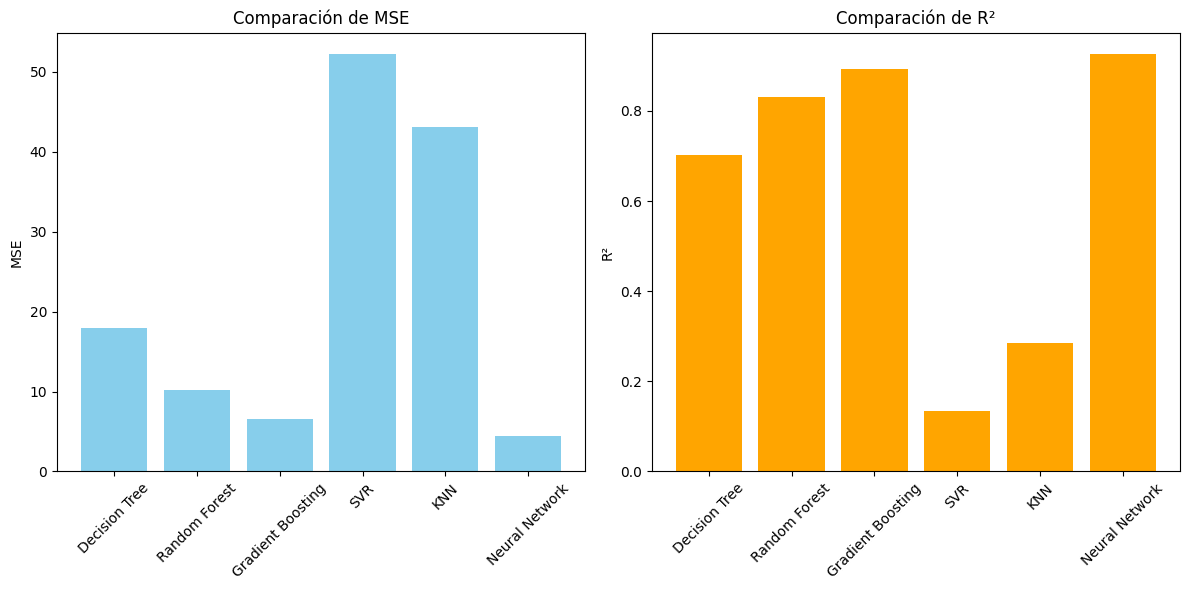

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Almacenar resultados de cada modelo en una lista
model_results = []

# Modelo 1: Decision Tree
model_results.append({
    'Model': 'Decision Tree',
    'Best Params': grid_search_dt.best_params_,
    'MSE': mean_squared_error(y_test, grid_search_dt.predict(X_test)),
    'R²': r2_score(y_test, grid_search_dt.predict(X_test))
})

# Modelo 2: Random Forest
model_results.append({
    'Model': 'Random Forest',
    'Best Params': grid_search_rf.best_params_,
    'MSE': mean_squared_error(y_test, grid_search_rf.predict(X_test)),
    'R²': r2_score(y_test, grid_search_rf.predict(X_test))
})

# Modelo 3: Gradient Boosting
model_results.append({
    'Model': 'Gradient Boosting',
    'Best Params': grid_search_gb.best_params_,
    'MSE': mean_squared_error(y_test, grid_search_gb.predict(X_test)),
    'R²': r2_score(y_test, grid_search_gb.predict(X_test))
})


# Modelo 5: SVR
model_results.append({
    'Model': 'SVR',
    'Best Params': grid_search_svr.best_params_,
    'MSE': mean_squared_error(y_test, grid_search_svr.predict(X_test)),
    'R²': r2_score(y_test, grid_search_svr.predict(X_test))
})

# Modelo 6: KNN
model_results.append({
    'Model': 'KNN',
    'Best Params': grid_search_knn.best_params_,
    'MSE': mean_squared_error(y_test, grid_search_knn.predict(X_test)),
    'R²': r2_score(y_test, grid_search_knn.predict(X_test))
})

# Modelo 7: Neural Network
model_results.append({
    'Model': 'Neural Network',
    'Best Params': grid_search_nn.best_params_,
    'MSE': mean_squared_error(y_test, grid_search_nn.predict(X_test)),
    'R²': r2_score(y_test, grid_search_nn.predict(X_test))
})

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(model_results)

# Mostrar los resultados en tabla
print(results_df)

# Gráficos para comparar los modelos
plt.figure(figsize=(12, 6))

# Comparar MSE
plt.subplot(1, 2, 1)
plt.bar(results_df['Model'], results_df['MSE'], color='skyblue')
plt.title('Comparación de MSE')
plt.ylabel('MSE')
plt.xticks(rotation=45)

# Comparar R²
plt.subplot(1, 2, 2)
plt.bar(results_df['Model'], results_df['R²'], color='orange')
plt.title('Comparación de R²')
plt.ylabel('R²')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [91]:
# Seleccionar el mejor modelo basado en el menor MSE y mayor R²
# Ordenar por MSE ascendente y luego por R² descendente
best_model = results_df.sort_values(by=['MSE', 'R²'], ascending=[True, False]).iloc[0]

# Mostrar el mejor modelo y sus detalles
print("El mejor modelo es:")
print(f"Modelo: {best_model['Model']}")
print(f"Mejores Parámetros: {best_model['Best Params']}")
print(f"MSE: {best_model['MSE']:.4f}")
print(f"R²: {best_model['R²']:.4f}")


El mejor modelo es:
Modelo: Neural Network
Mejores Parámetros: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
MSE: 4.4241
R²: 0.9268


In [93]:
# Guardar las columnas de las características usadas en el entrenamiento
feature_columns = X_train.columns


In [98]:
# Paso 3: Entrenar el modelo con los datos de entrenamiento (df_pivoted)
X_train = df_pivoted.drop(columns=['daily_precipitation'])  # Suponiendo que 'daily_precipitation' es la columna objetivo
y_train = df_pivoted['daily_precipitation']  # La columna que se quiere predecir

# Paso 4: Ajustar el modelo seleccionado (mejor modelo encontrado)
best_trained_model.fit(X_train, y_train)

# Paso 5: Hacer la predicción para mañana con los datos actualizados
# Suponiendo que tienes un DataFrame para los datos de predicción
X_predict = df_pivoted.drop(columns=['daily_precipitation']).tail(1)  # Tomamos el último registro para predecir el siguiente

# Predicción para mañana
predicted_rain = best_trained_model.predict(X_predict)

# Mostrar el resultado
print(f'Predicción de lluvia para mañana: {predicted_rain[0]} mm')



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_base.py:172: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_base.py:172: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:570: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/py

Predicción de lluvia para mañana: -2.98855184441676 mm
